In [1]:
# Import Numpy and Matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Astropy for FITS handling and modeling
from astropy.io import fits
from astropy.modeling import models, fitting
from astropy import modeling

# Import BlazeFit for fitting polynomial
from pyutil.blazeFit import blazeFit

# Import AFS Algorithm for continuum normalization
import sys
sys.path.append("./Blaze_Function")
from AFS import *

# Import Pandas to work with AFS algorithm
import pandas as pd

# Import Scipy and Numpy derivative works
import scipy.optimize
from scipy.signal import savgol_filter
from scipy.misc import derivative
from numpy import diff

# Import Models for Fitting
from lmfit.models import GaussianModel, SkewedGaussianModel, VoigtModel

# Import Time
import time

# Import to Work Across Files
import os

In [2]:
# Choose Graph and Plotting Style
plt.style.use(['ggplot'])

In [3]:
# Open FITS File
hdul = fits.open('./NEID_Tutorials-main/neidL2_20210208T191024.fits')
hdul.info()

Filename: ./NEID_Tutorials-main/neidL2_20210208T191024.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     740   ()      
  1  SCIFLUX       1 ImageHDU        12   (9216, 122)   float32   
  2  SKYFLUX       1 ImageHDU        12   (9216, 122)   float32   
  3  CALFLUX       1 ImageHDU        12   (9216, 122)   float32   
  4  SCIVAR        1 ImageHDU        12   (9216, 122)   float32   
  5  SKYVAR        1 ImageHDU        12   (9216, 122)   float32   
  6  CALVAR        1 ImageHDU        12   (9216, 122)   float32   
  7  SCIWAVE       1 ImageHDU      2253   (9216, 122)   float64   
  8  SKYWAVE       1 ImageHDU      2253   (9216, 122)   float64   
  9  CALWAVE       1 ImageHDU      2253   (9216, 122)   float64   
 10  TELLURIC      1 ImageHDU        12   (9216, 122)   float64   
 11  SKY           1 ImageHDU         8   ()      
 12  CCFS          1 ImageHDU       515   (804, 122)   float64   
 13  ACTIVITY      1 BinTableHDU     41 

In [4]:
# Get Flux and Wave Data
flux = hdul['SCIFLUX'].data
wave = hdul['SCIWAVE'].data

# Print Flux and Wave Data Shape 
print('Flux Data Shape:', flux.shape)
print('Wave Data Shape:', wave.shape) # both have 122 spectral orders!

Flux Data Shape: (122, 9216)
Wave Data Shape: (122, 9216)


In [5]:
# Universal Graph Styling
COLOR = 'k'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams["font.family"] = "Helvetica"
plt.rcParams.update({'figure.max_open_warning': 0})

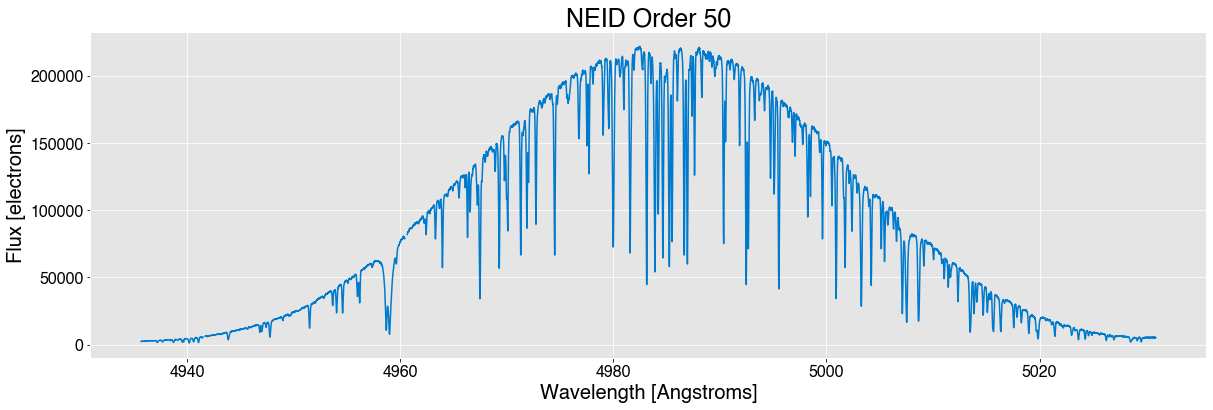

In [6]:
# Working with Order 50 First (40-110)
order = 50
x = wave[order,:]
y = flux[order,:]

# Plot Order 50
plt.figure(figsize=(20,6))
plt.plot(x, y, color='#007acc')
plt.title('NEID Order {}'.format(order), fontsize=25)
plt.xlabel('Wavelength [Angstroms]', fontsize=20)
plt.ylabel('Flux [electrons]', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

Min Wavelength: 4935.698028823567
Max Wavelength: 5030.89825568633


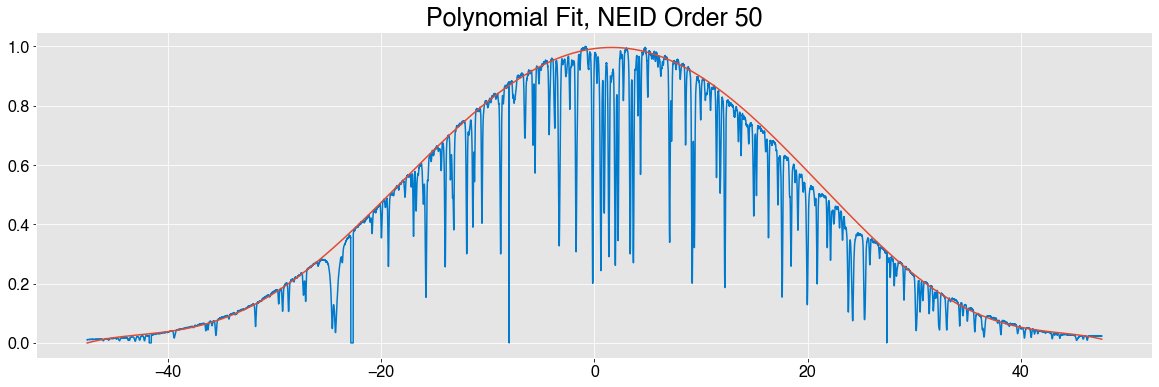

In [7]:
# Get Wavelength Range
print('Min Wavelength:', min(x))
print('Max Wavelength:', max(x))

# Replace NaN Values with Zero
x = np.nan_to_num(x)
y = np.nan_to_num(y)

# Fit Blaze Function with Polynomial
wave_spread = max(x) - min(x)
z = blazeFit(x, y, 0.01, numcalls=50)

# Center Wavelength Range about Zero
wave_center = x - min(x) - wave_spread/2.

# Normalize the Spectrum & Make Function
norm_spec = y/max(y)
cfit = np.poly1d(z)

# Plot the Original Spectrum
plt.figure(figsize=(20,6))
plt.title('Polynomial Fit, NEID Order {}'.format(order), fontsize=25)
plt.plot(wave_center, norm_spec, color='#007acc')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Plot the Polynomial Fit
plt.plot(wave_center, cfit(wave_center));

Data Shape: (9216, 2)


Text(0, 0.5, 'Normalized Intensity')

<Figure size 432x288 with 0 Axes>

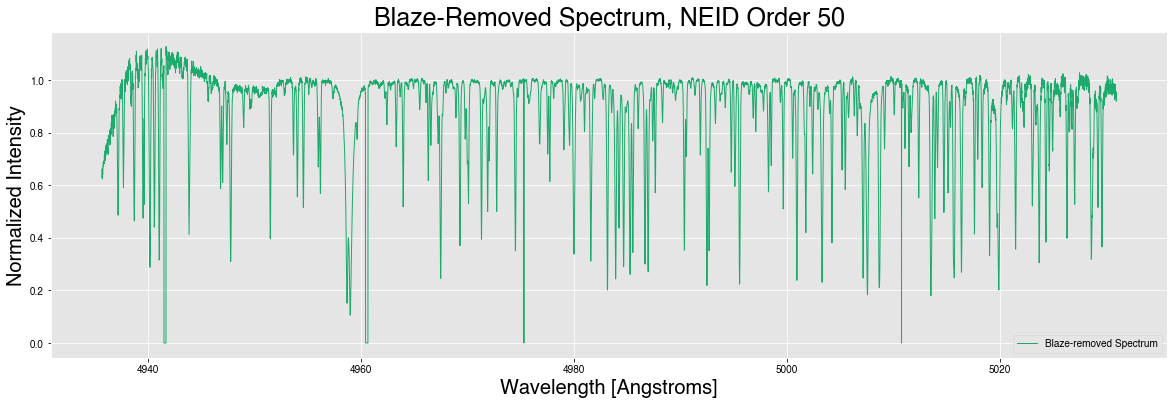

In [8]:
# Replace NaN Values with Zero of Numpy Array for Wave and Flux
x = np.nan_to_num(np.array(wave[order,:]))
y = np.nan_to_num(np.array(flux[order,:]))

# Combine 'x' and 'y' into Single Array
order_data = np.stack((x, y), axis=1)

# Pass Data through AFS Algorithm
pd_order_data = pd.DataFrame(order_data)
result= AFS(pd_order_data,6,0.95,0.25)
print('Data Shape:', order_data.shape) # it's a nx2 array! 

# Plot the Blaze-Removed spectrum
plt.clf()
plt.figure(figsize=(20,6))
plt.plot(pd_order_data["wv"], result, 'b', linewidth=1, label='Blaze-removed Spectrum', color='#1DAB6D')
plt.legend(loc='lower right')
plt.title('Blaze-Removed Spectrum, NEID Order {}'.format(order), fontsize=25)
plt.xlabel('Wavelength [Angstroms]', fontsize=20)
plt.ylabel('Normalized Intensity', fontsize=20)

In [9]:
# First Derivative of Blaze-Removed Spectrum (To Find Zero-Crossings)
derivative = np.gradient(result) 

# Second Derivative of Blaze-Removed Spectrum (To Remove Most Noise)
derivative2 = np.gradient(derivative) 

# Smoothed First & Second Derivatives
smooth_derivative = savgol_filter(derivative, 11, 5)
smooth_derivative2 = savgol_filter(derivative2, 11, 5)

# Third Derivative of Blaze-Removed Spectrum (To Remove Duplicate Points)
derivative3 = np.gradient(smooth_derivative2) 

# Sort List to Split into 3 Parts and Find Avg Value of Upper Part to determine 2nd Der 'Bump' Thresholds
sortedlist_for2 = np.sort(smooth_derivative2)
splitlist = np.array_split(sortedlist_for2, 3)

# Second Derivative 'Bump' Threshhold
print('2nd Derivative Threshold: ', np.mean(splitlist[2]))

# Find Zero Crossings
zero_crossing1 = np.where((smooth_derivative2 > np.mean(splitlist[2])))[0] 
zero_crossing2 = np.where(np.diff(np.signbit(derivative3)))

zerolist1 = zero_crossing1.tolist()
zerolist2 = np.array(zero_crossing2).tolist()
zero_crossings = np.array(list(set(zerolist1).intersection(zerolist2[0]))) # final list of points!

2nd Derivative Threshold:  0.006074568825640712


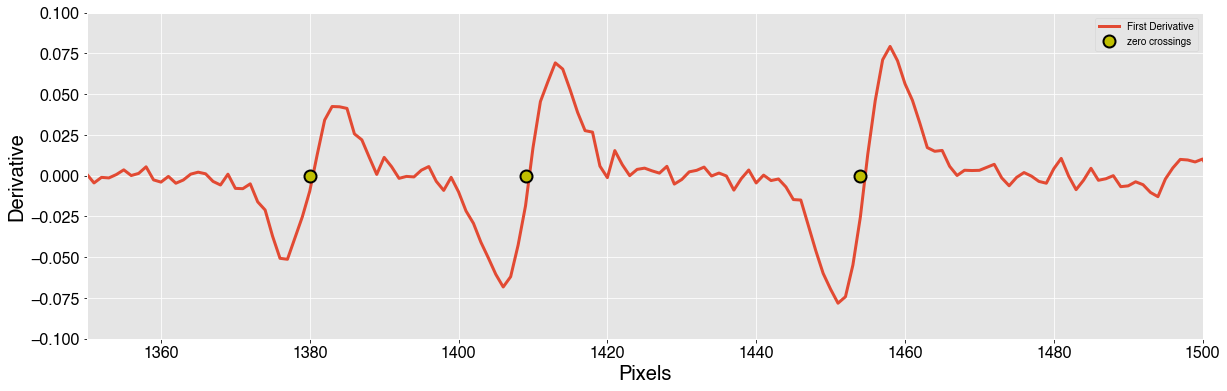

In [10]:
# Plot the First Derivative between pixels 1350 and 1500 for Analysis
plt.figure(figsize=(20,6))
plt.plot(derivative,lw=3,label='First Derivative')
plt.plot(zero_crossings,np.zeros(len(zero_crossings)),'yo',ms=12,markeredgecolor='k',
         markeredgewidth=2,label='zero crossings')
plt.xlim(1350,1500) 
plt.ylim(-0.1,0.1)
plt.xlabel('Pixels', fontsize=20)
plt.ylabel('Derivative', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend()

plt.show()

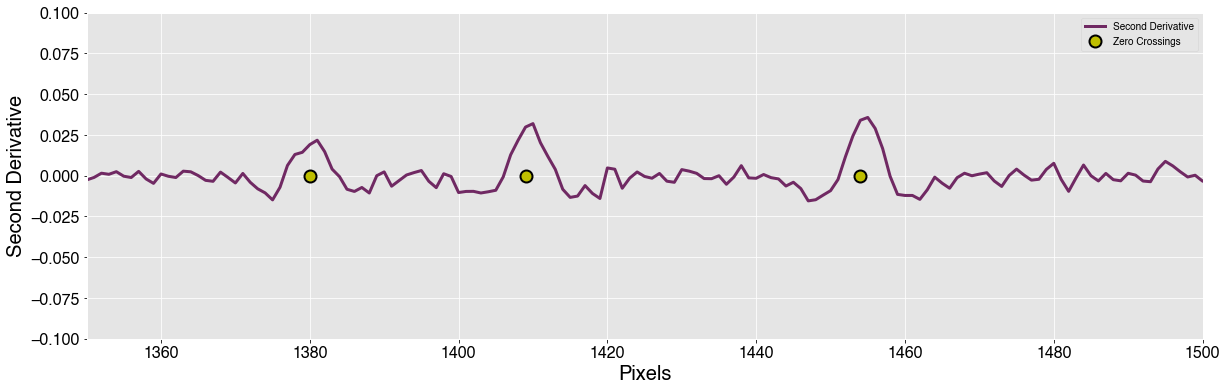

In [11]:
# Plot the Second Derivative between pixels 1350 and 1500 for Analysis
plt.figure(figsize=(20,6))
plt.plot(derivative2,lw=3,label='Second Derivative', color='#702963')
plt.plot(zero_crossings,np.zeros(len(zero_crossings)),'yo',ms=12,markeredgecolor='k',
         markeredgewidth=2,label='Zero Crossings')
plt.xlim(1350,1500)
plt.ylim(-0.1,0.1)
plt.xlabel('Pixels', fontsize=20)
plt.ylabel('Second Derivative', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend()

plt.show()

In [12]:
# Create List of Peak Findings and Sort List
good_lines = []
for zero_crossing in zero_crossings:
    # (Arpita) cut off pixels at very edge of detector
    if 20 < zero_crossing < 9000: 
        
        # (Arpita) Make sure first derivate is going from negative to positive
        slope = smooth_derivative[zero_crossing-1] - smooth_derivative[zero_crossing+1]
        
        # (Arpita) Im setting these numbers after experimenting with different slope cuts
        if -0.38 < slope < -0.01:
            good_lines.append(zero_crossing)
good_lines.sort()

# Delete Really Close-to-Each-Other Values
for index, i in enumerate(good_lines):
    if good_lines[-1] == i:
        break
        
    i_up = good_lines[index+1]
    if ((i_up-i) < 18):
        good_lines.remove(i)
        good_lines.remove(i_up)

List of peak findings: [41, 111, 150, 176, 202, 226, 287, 297, 337, 368, 402, 437, 464, 547, 596, 614, 750, 888, 916, 1011, 1207, 1380, 1409, 1454, 1786, 1810, 1863, 1935, 2094, 2166, 2221, 2352, 2402, 2420, 2440, 2499, 2519, 2641, 2674, 2742, 2848, 2973, 3127, 3203, 3397, 3414, 3533, 3583, 3620, 3710, 3764, 3909, 3945, 3980, 4009, 4050, 4107, 4131, 4177, 4238, 4267, 4307, 4330, 4395, 4592, 4610, 4738, 4799, 4819, 4877, 5025, 5057, 5104, 5231, 5256, 5329, 5377, 5403, 5519, 5610, 5652, 5807, 5900, 5998, 6099, 6132, 6224, 6253, 6314, 6359, 6535, 6718, 6749, 6791, 6895, 7023, 7068, 7097, 7168, 7213, 7240, 7361, 7505, 7542, 7590, 7675, 7761, 7784, 7976, 8032, 8076, 8172, 8253, 8334, 8414, 8433, 8591, 8624, 8651, 8713, 8741, 8778, 8832, 8857, 8892, 8955, 8977]


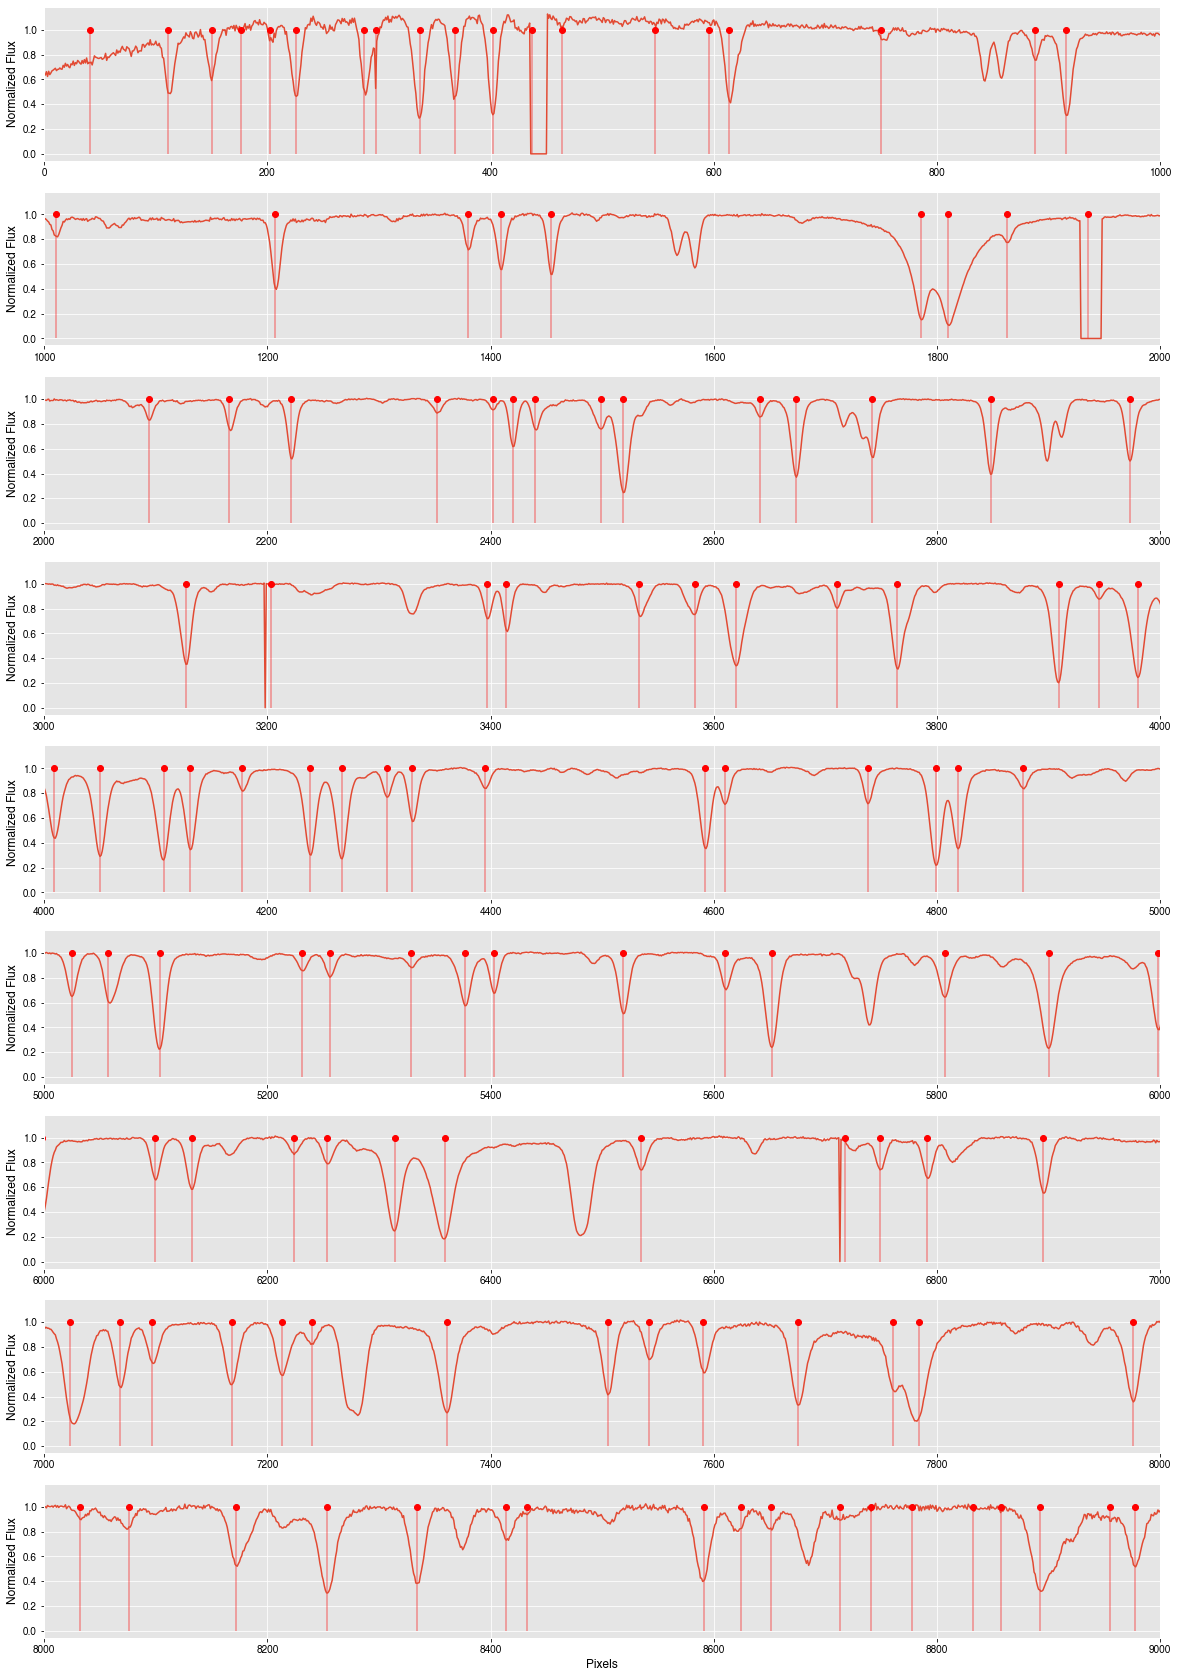

In [13]:
# Print List of Peak Findings
print('List of peak findings:',good_lines)

# Plot Peak Finding Lines 
fig, axs = plt.subplots(nrows=9,figsize=(20,30))
for i in range(9):
    axs[i].plot(result)
    axs[i].plot(good_lines,np.repeat(1,len(good_lines)),'ro')
    axs[i].vlines(good_lines,0,1,color='r',alpha=0.4)
    axs[i].set_xlim(i*1000,(i+1)*1000)
    axs[i].set_ylabel('Normalized Flux')
axs[i].set_xlabel('Pixels')
plt.show()

In [14]:
# Fit Skewed Gaussian to the 112th Line as Test
pixrange = 15
linenum = 112

# (Arpita) Chunk/Schunk Work
schunk = result[(good_lines[linenum]-pixrange):(good_lines[linenum]+pixrange)]
upside = -schunk + 1
xchunk = np.arange(len(schunk))

# Skewed Gaussian Model 'x' and 'y' Variables to Use
skgauss_x = good_lines[linenum]+xchunk
skgauss_y = upside

# Create Skewed Gaussian Model Fit
mod = SkewedGaussianModel()
pars = mod.guess(skgauss_y, x=skgauss_x)
out = mod.fit(skgauss_y, pars, x=skgauss_x)

[[Model]]
    Model(skewed_gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 75
    # data points      = 30
    # variables        = 4
    chi-square         = 0.00693468
    reduced chi-square = 2.6672e-04
    Akaike info crit   = -243.172527
    Bayesian info crit = -237.567737
[[Variables]]
    amplitude:  12.9458901 +/- 0.11141766 (0.86%) (init = 10.90966)
    center:     8274.01530 +/- 0.45680141 (0.01%) (init = 8268.5)
    sigma:      9.60444076 +/- 0.38571899 (4.02%) (init = 6.5)
    gamma:     -1.16398134 +/- 0.16235200 (13.95%) (init = 0)
[[Correlations]] (unreported correlations are < 0.250)
    C(center, gamma)    = -0.981
    C(center, sigma)    =  0.976
    C(sigma, gamma)     = -0.965
    C(amplitude, sigma) =  0.268


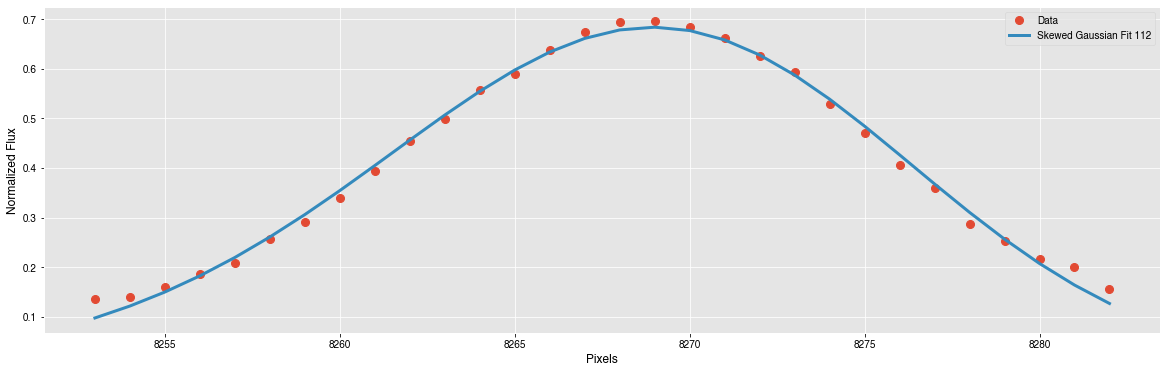

In [15]:
# Plot Skewed Gaussian Model Fit
plt.figure(figsize=(20,6))
plt.plot(skgauss_x, skgauss_y, 'o',ms=8,label='Data')
plt.plot(skgauss_x, out.best_fit,lw=3,label='Skewed Gaussian Fit '+str(linenum))
plt.xlabel('Pixels')
plt.ylabel('Normalized Flux')
plt.legend()

# Print Skewed Gaussian Parameters Report
print(out.fit_report(min_correl=0.25))

Total # of Spectral Skew-Gaussain Representations: 89
Total # of 'Bad' Fits Thrown Out: 38


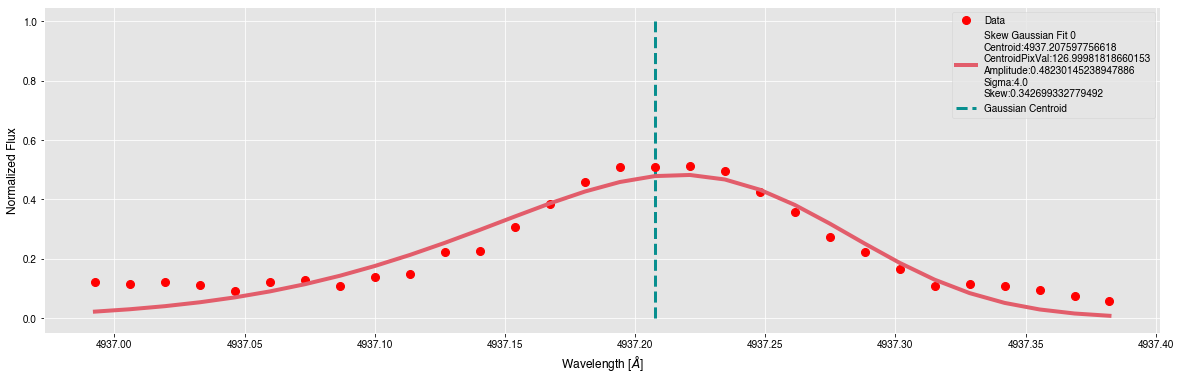

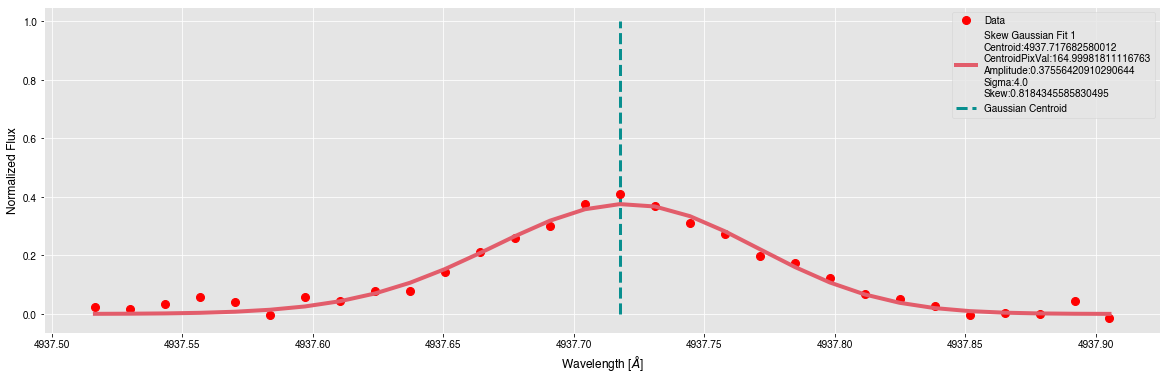

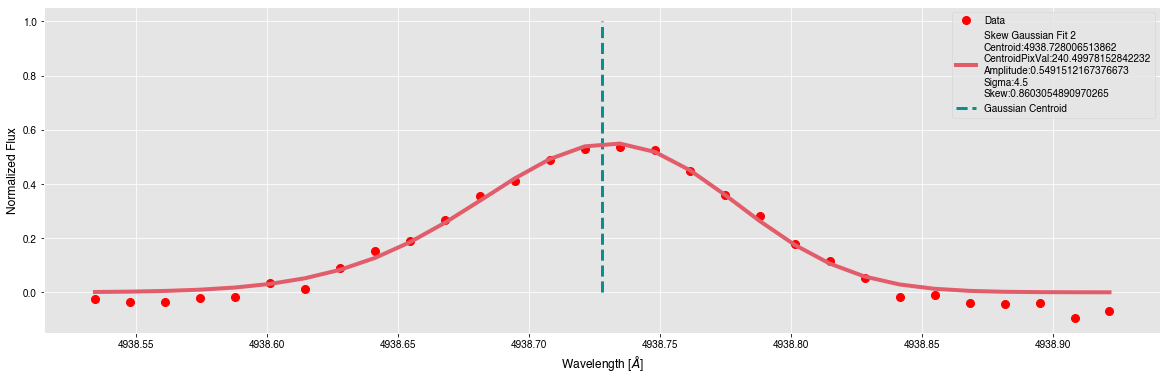

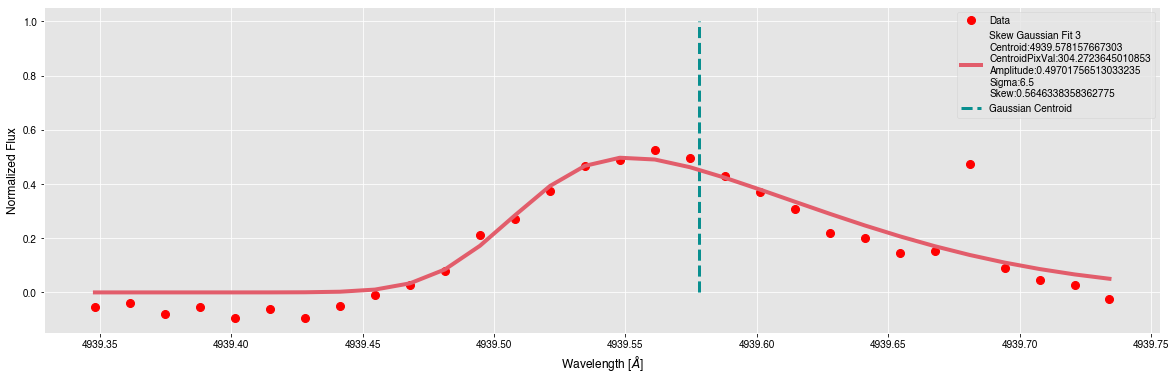

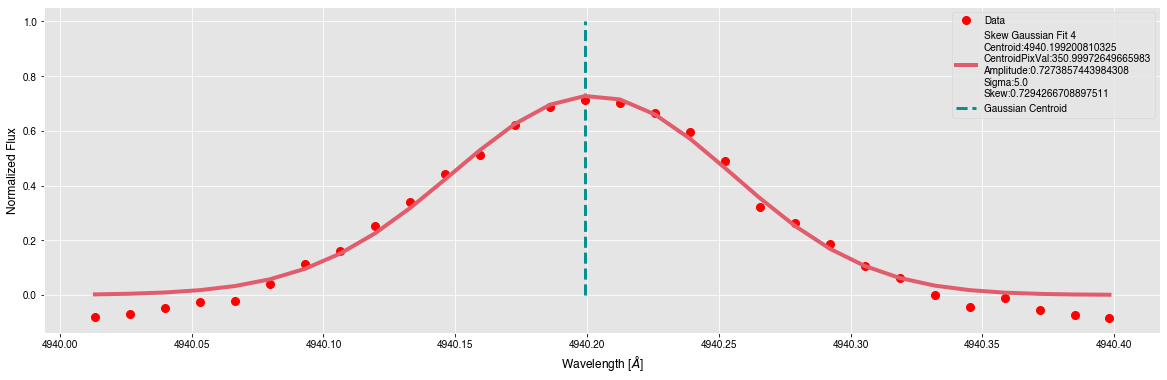

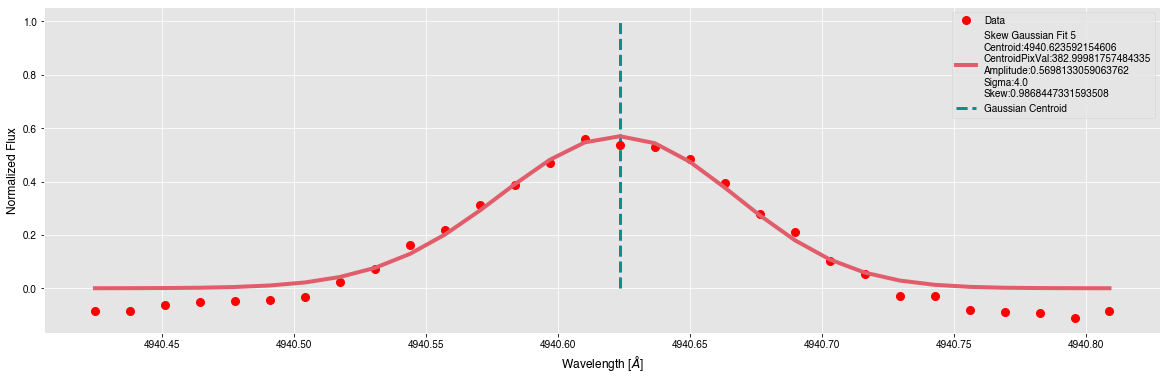

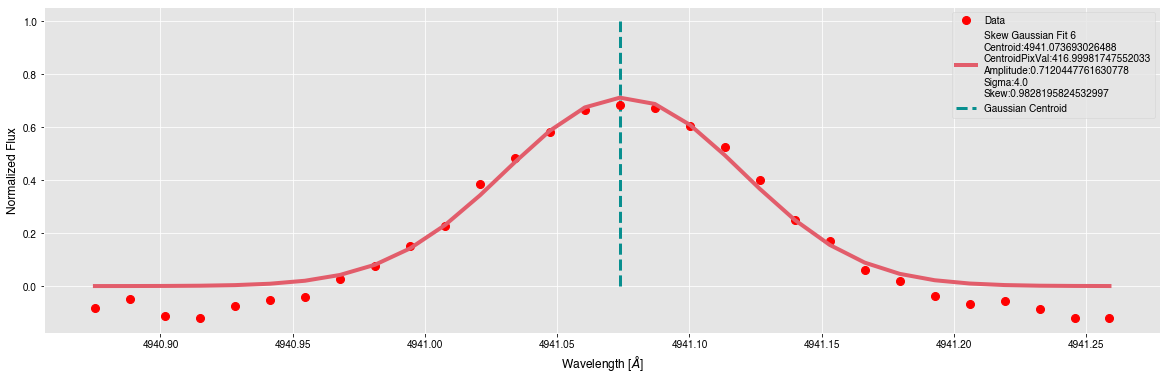

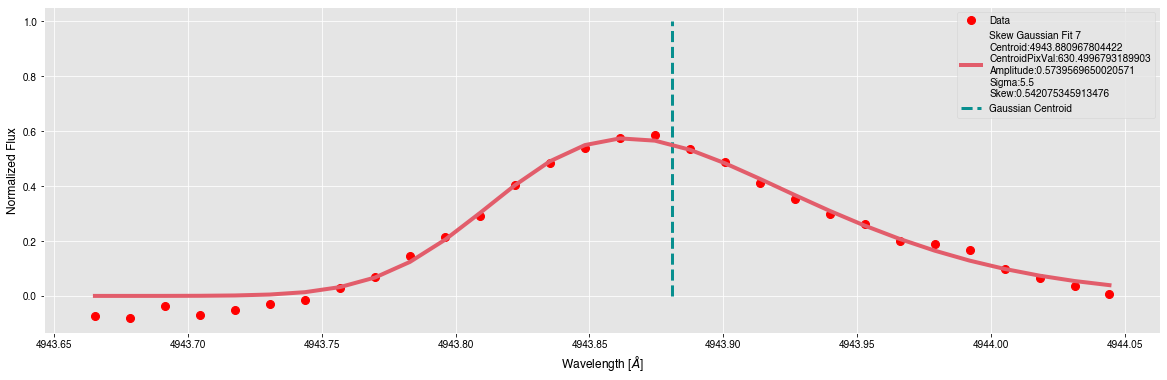

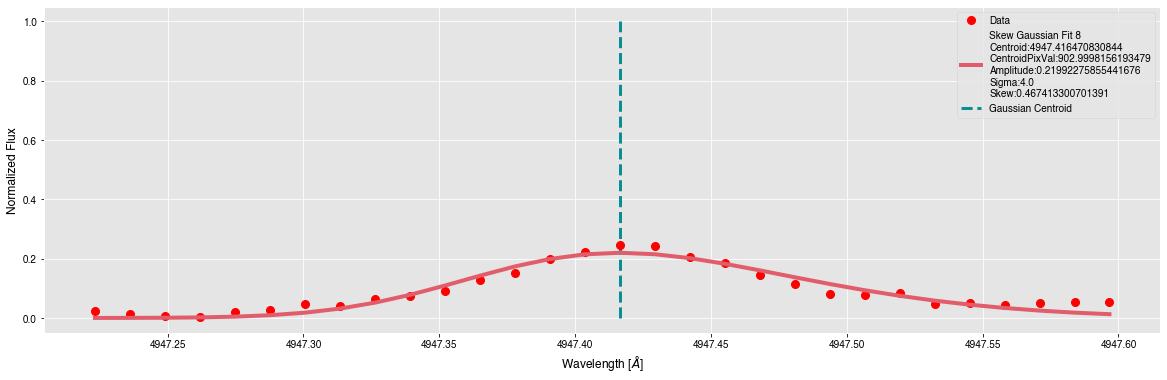

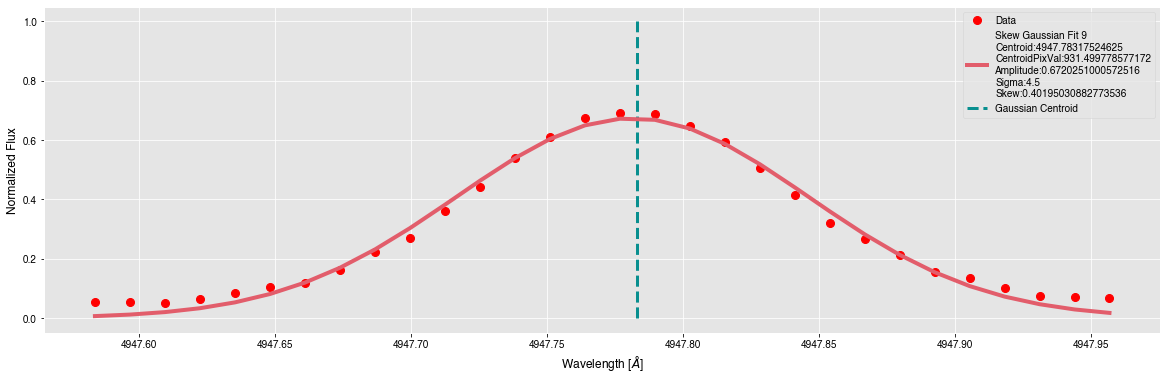

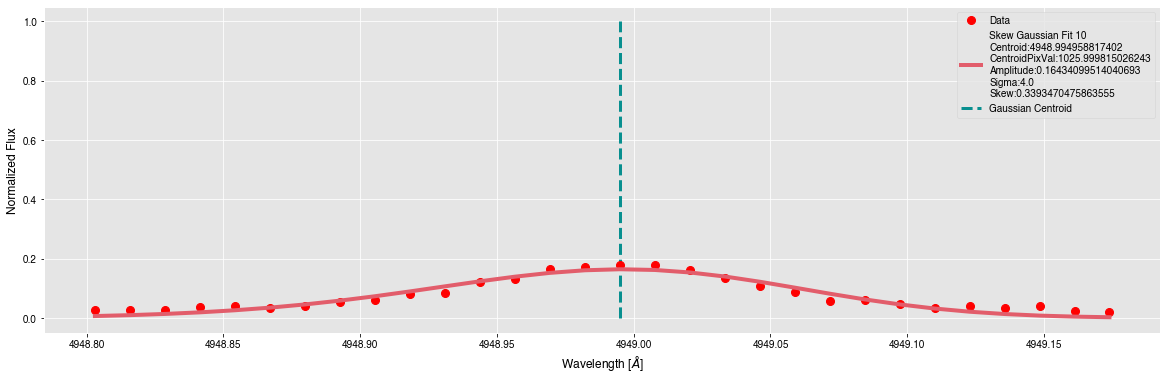

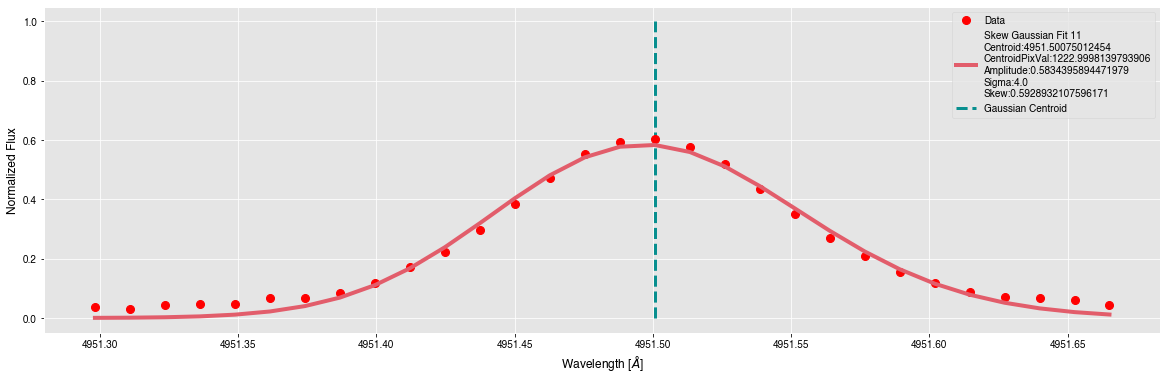

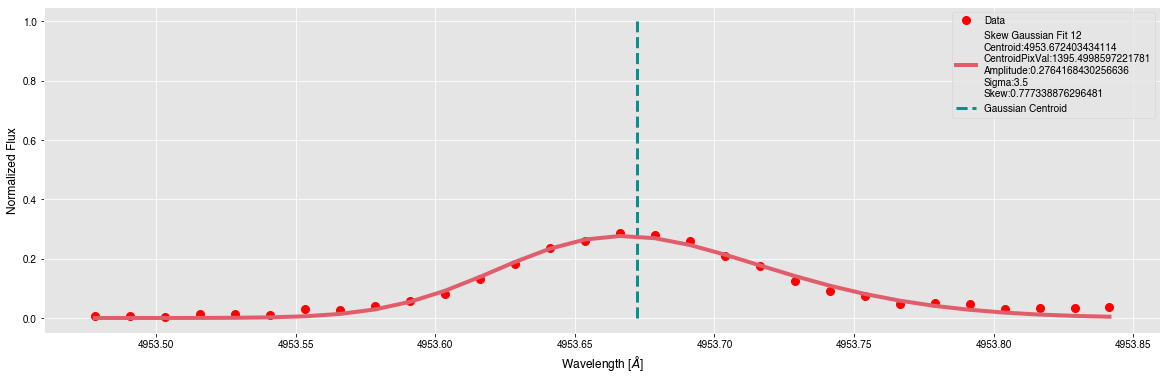

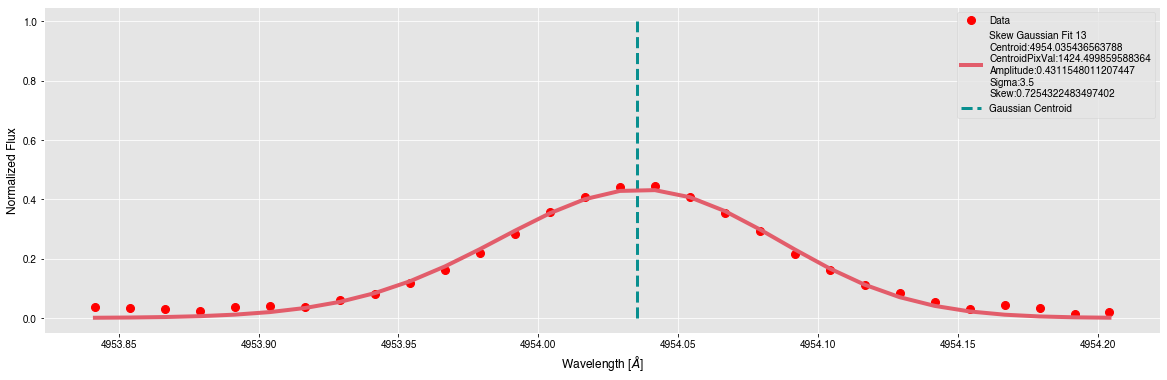

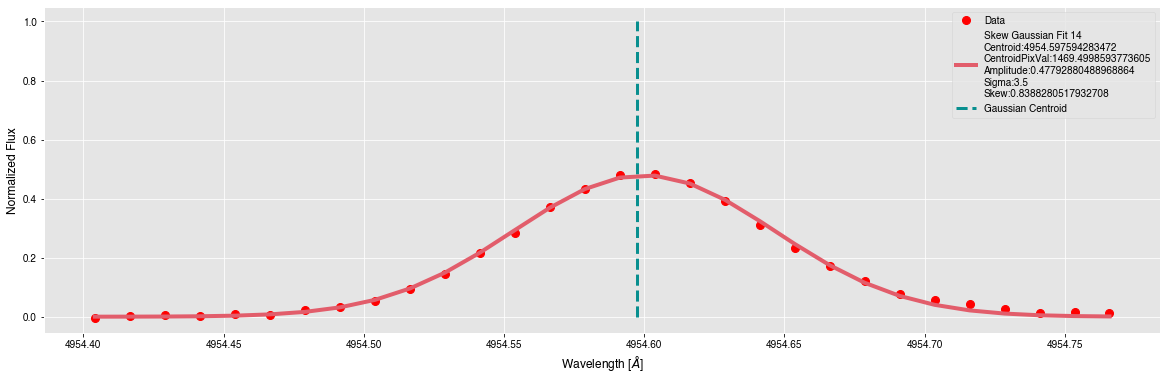

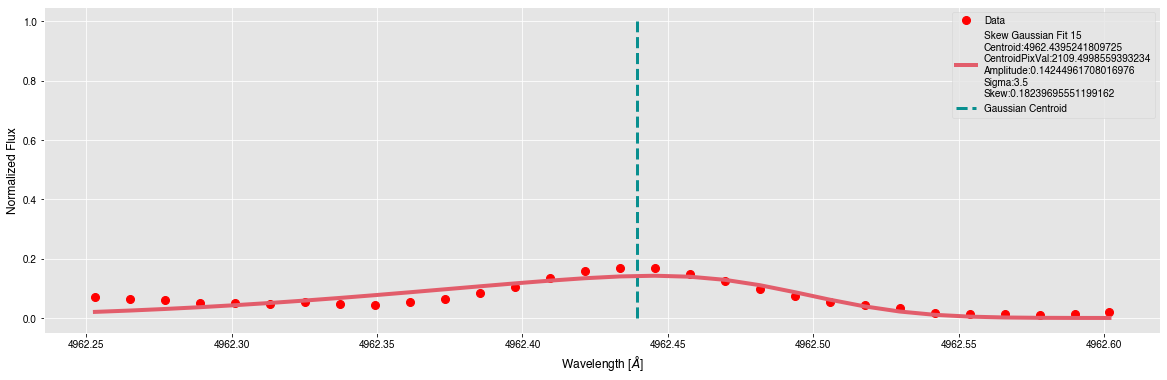

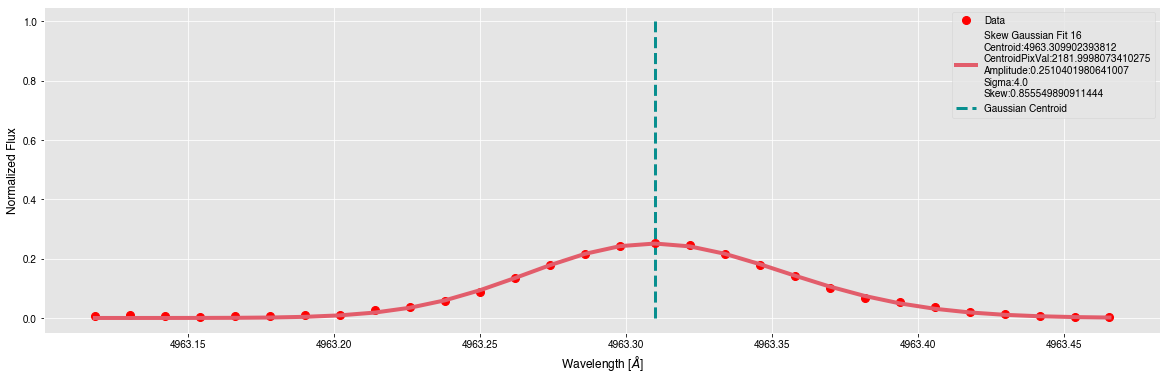

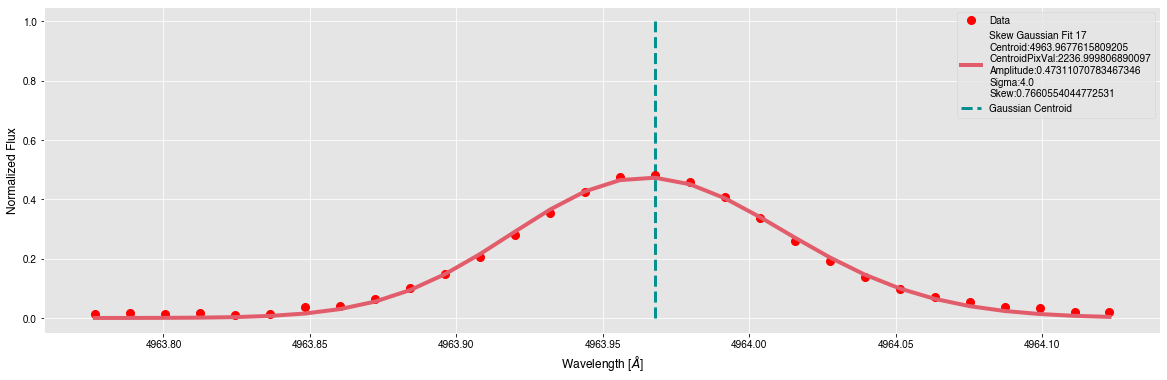

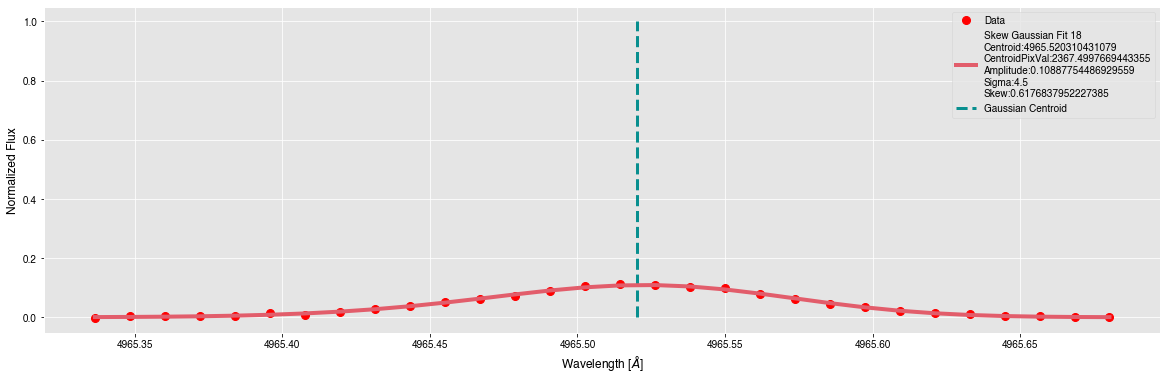

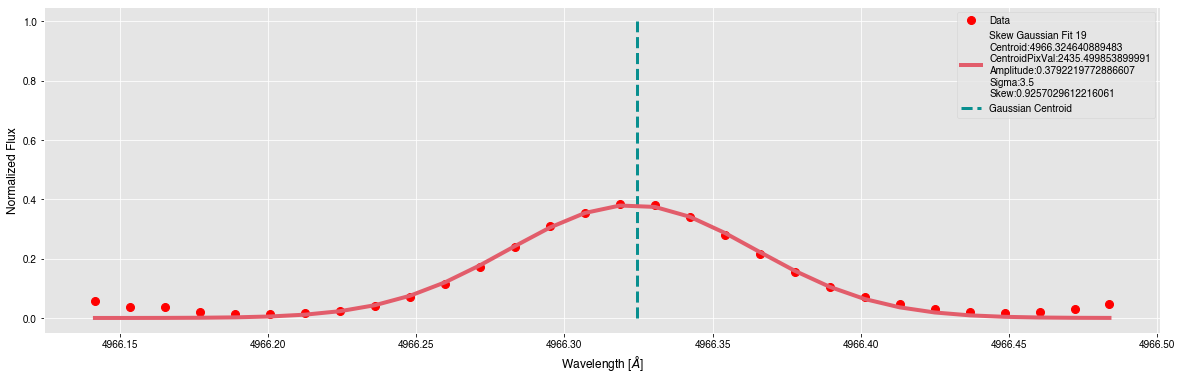

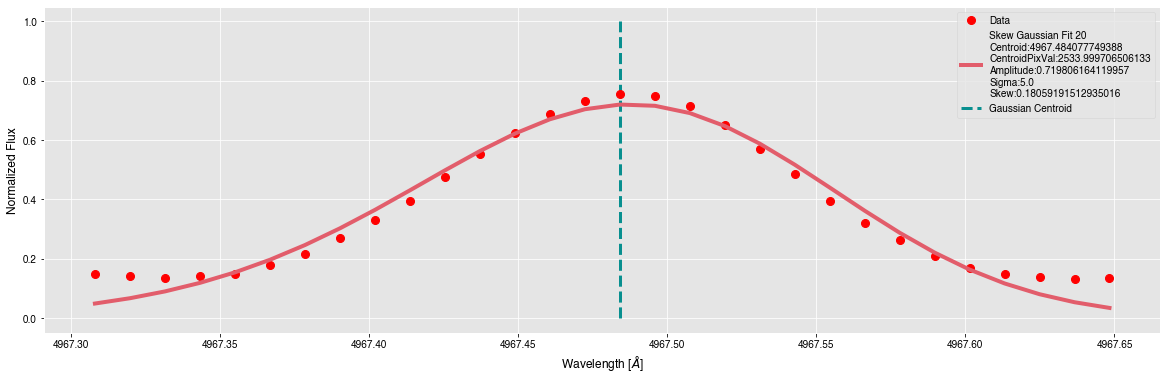

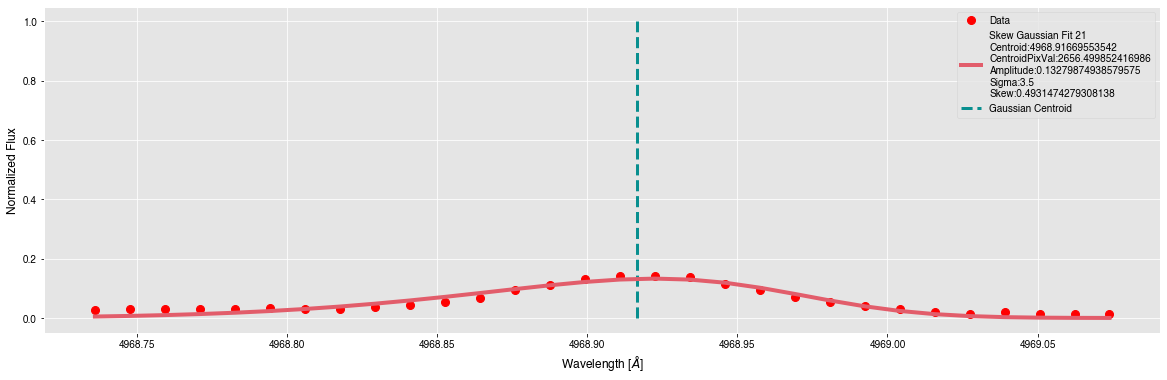

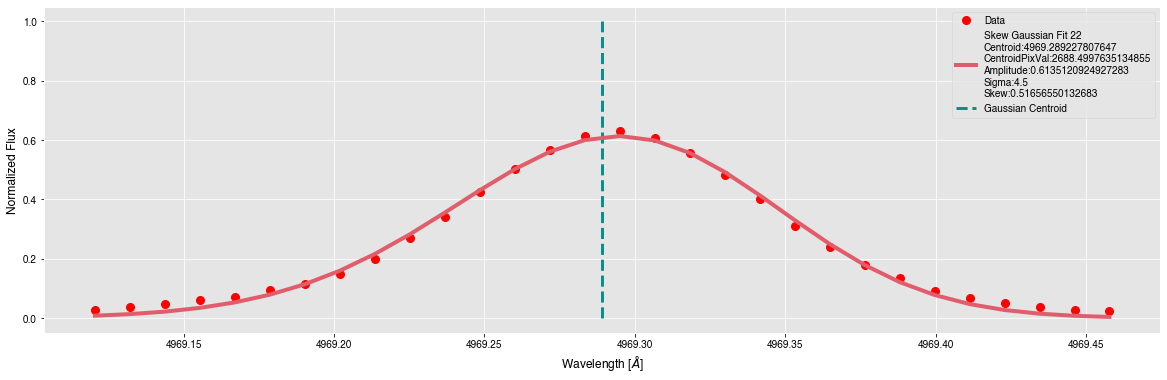

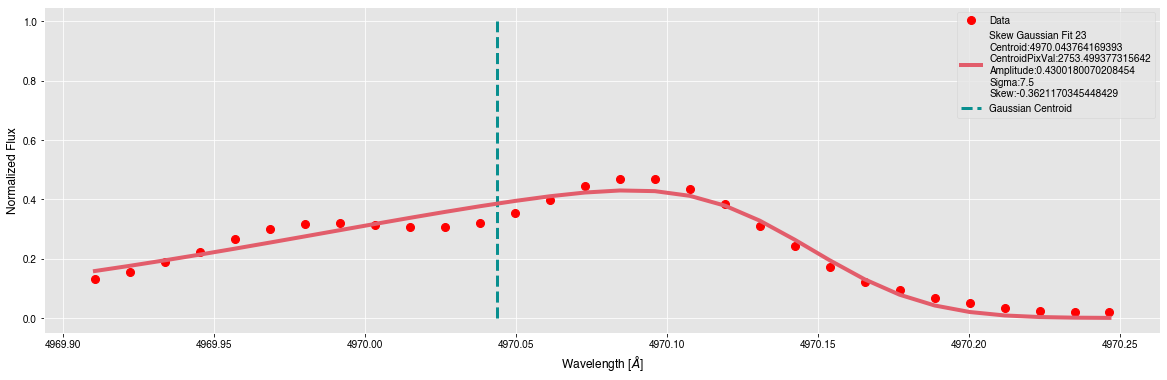

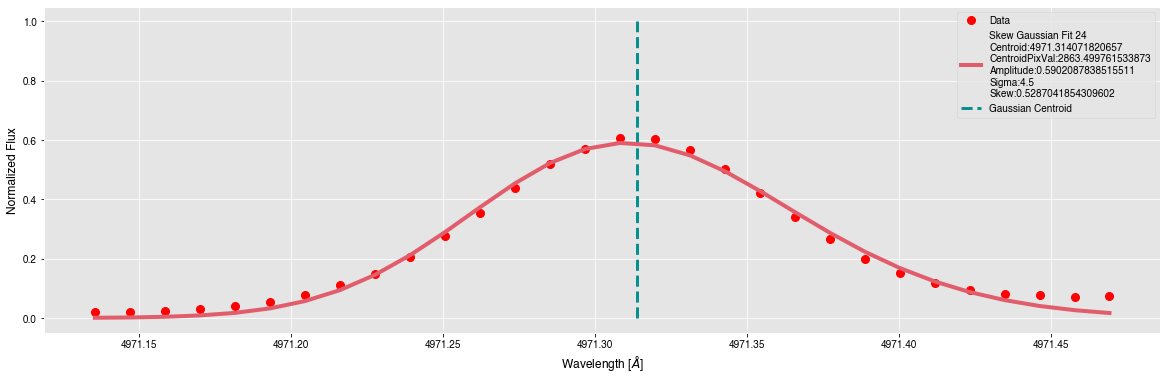

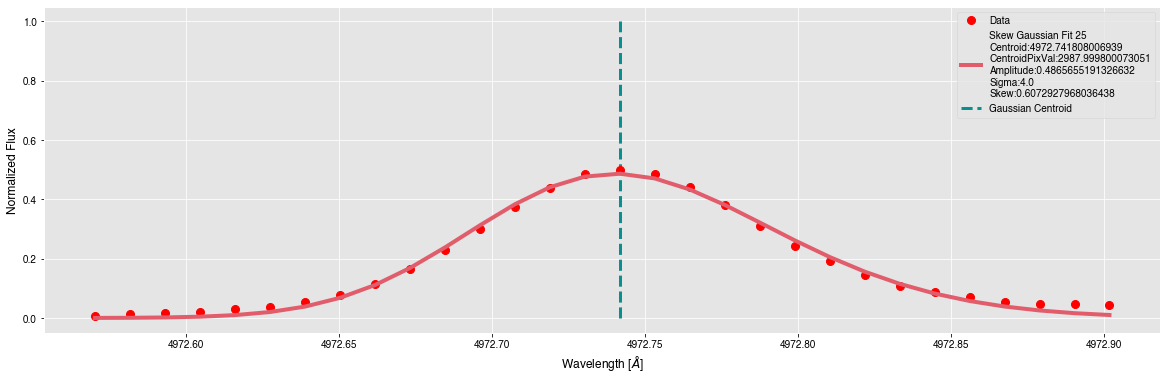

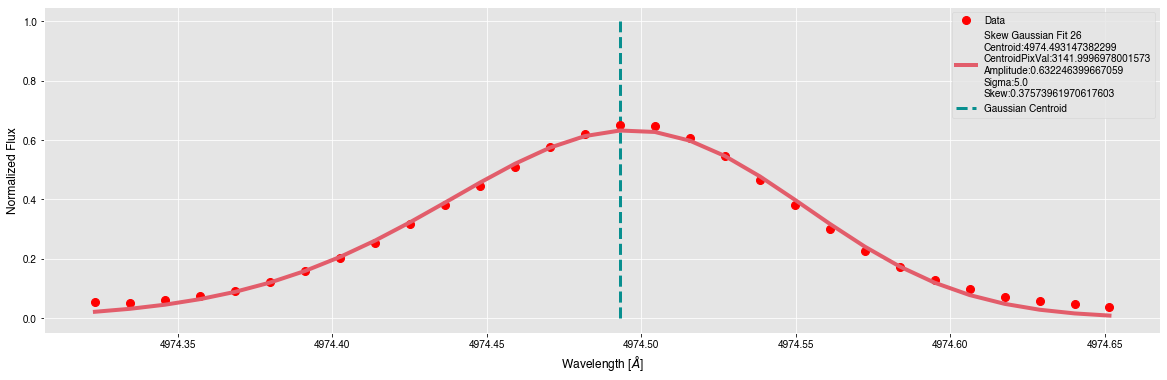

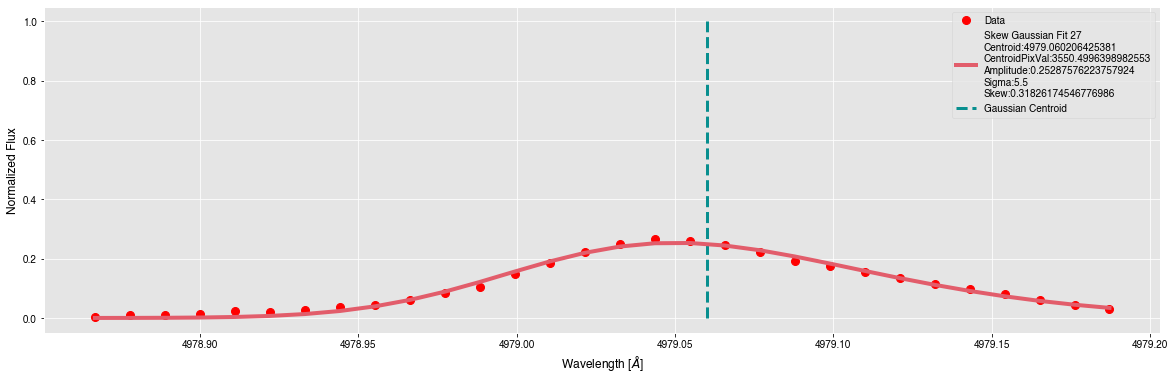

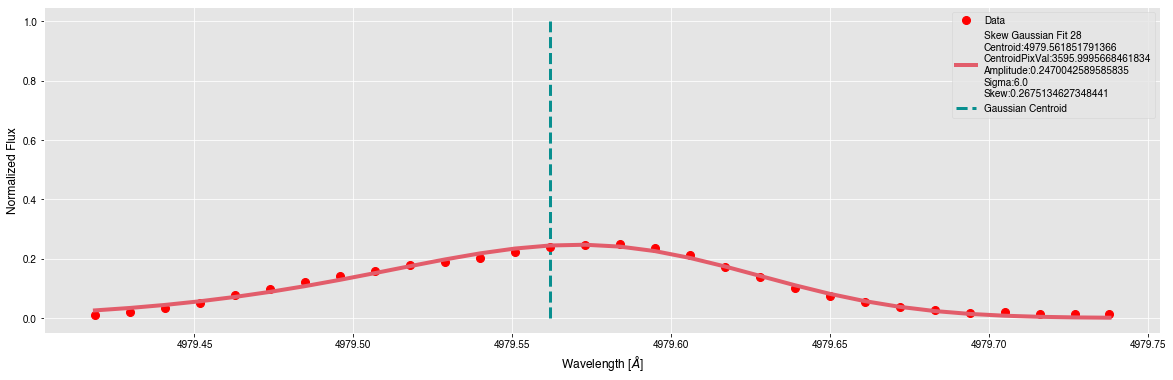

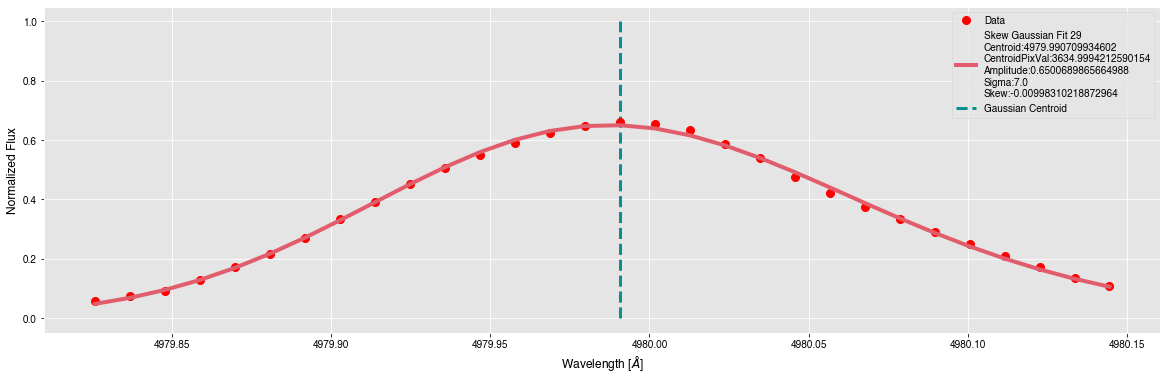

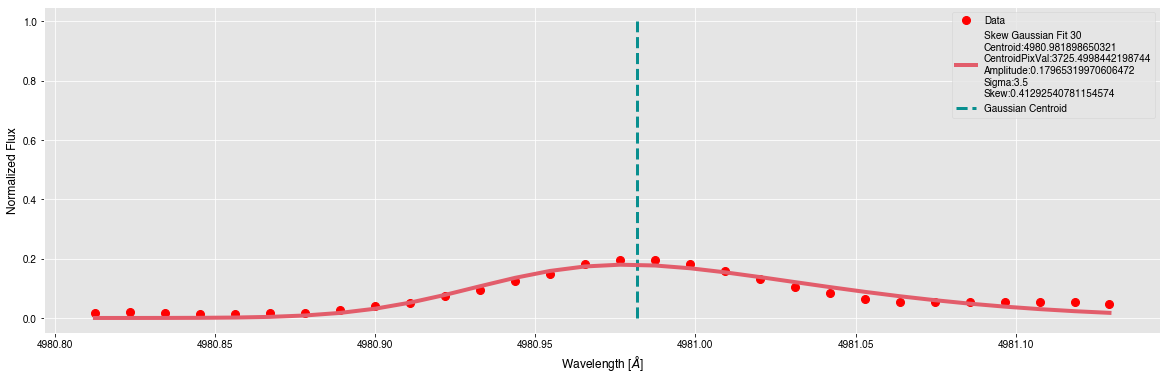

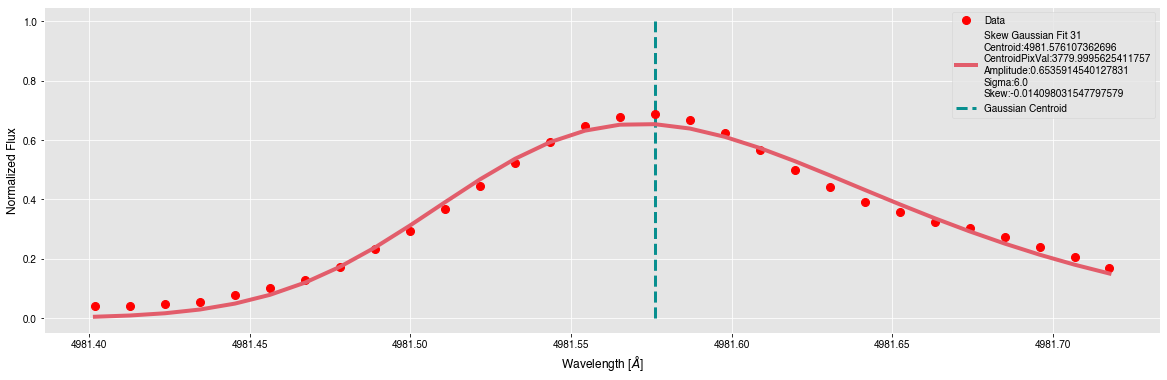

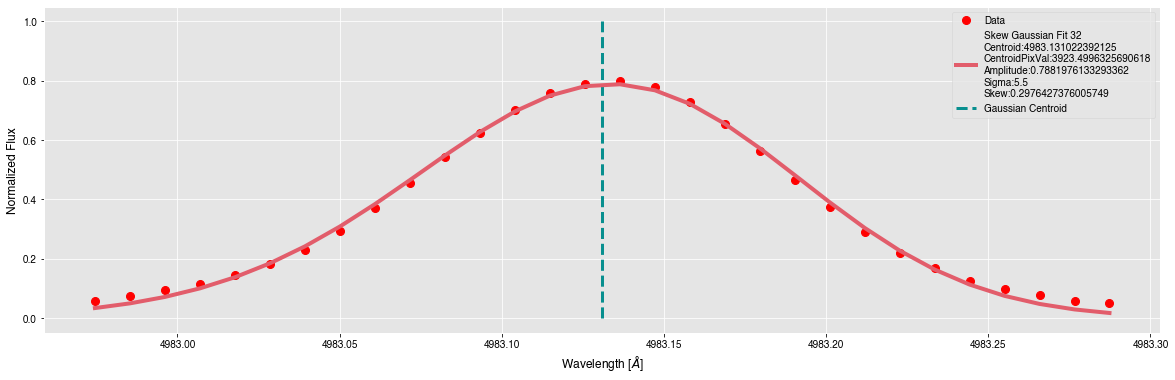

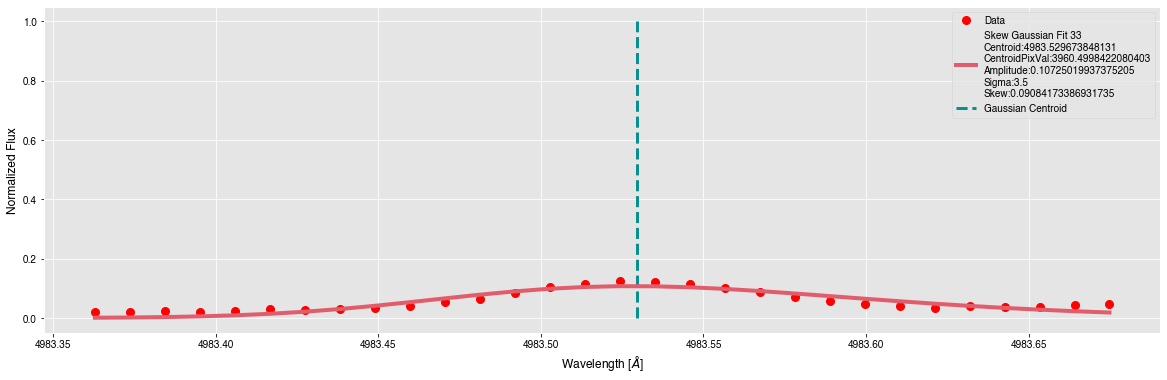

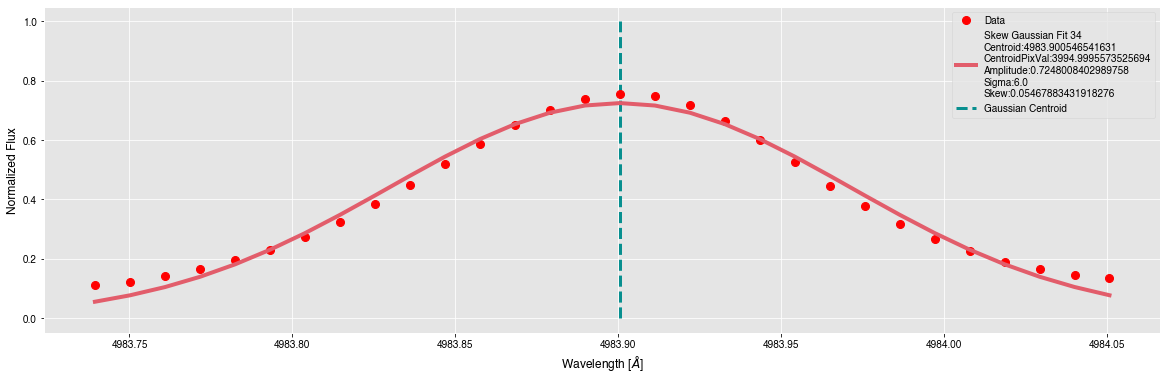

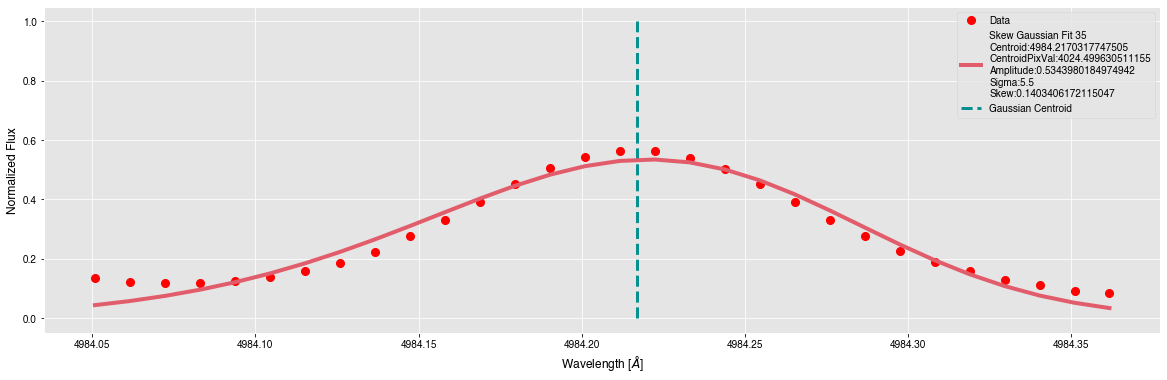

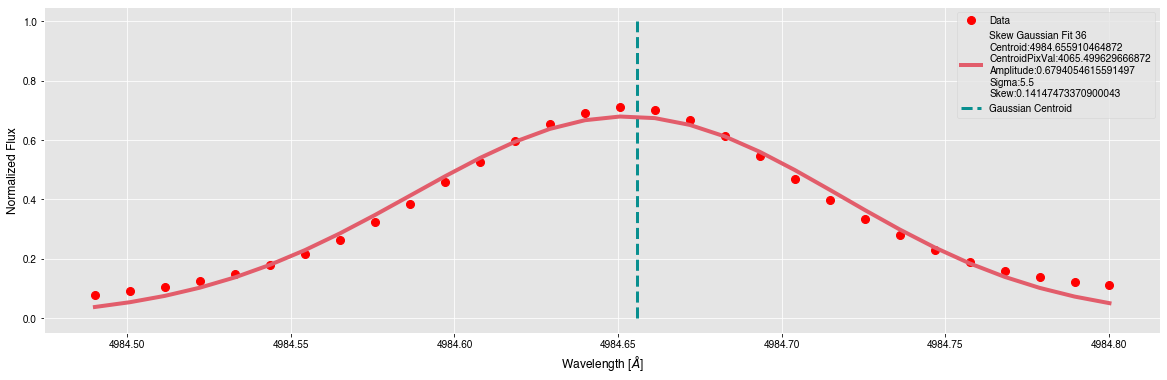

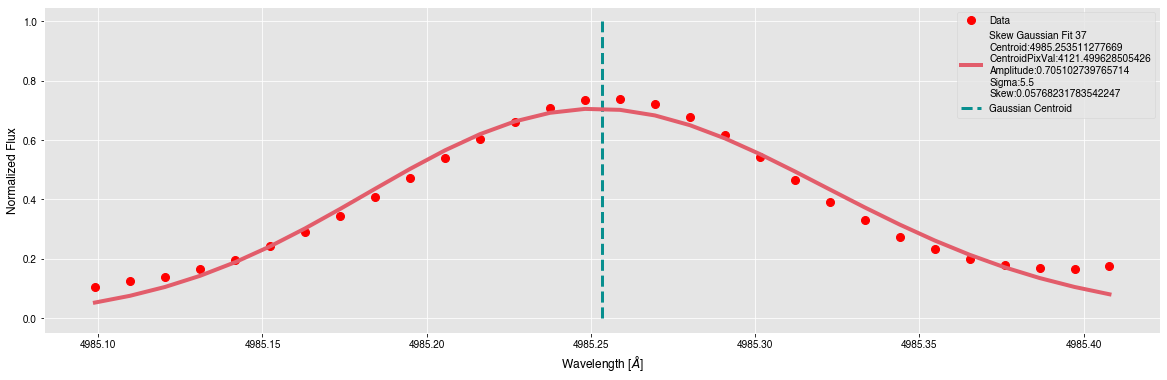

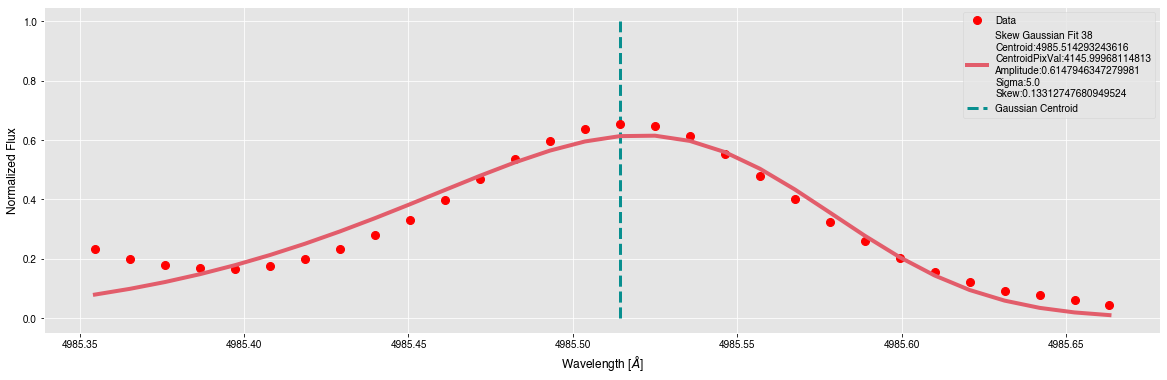

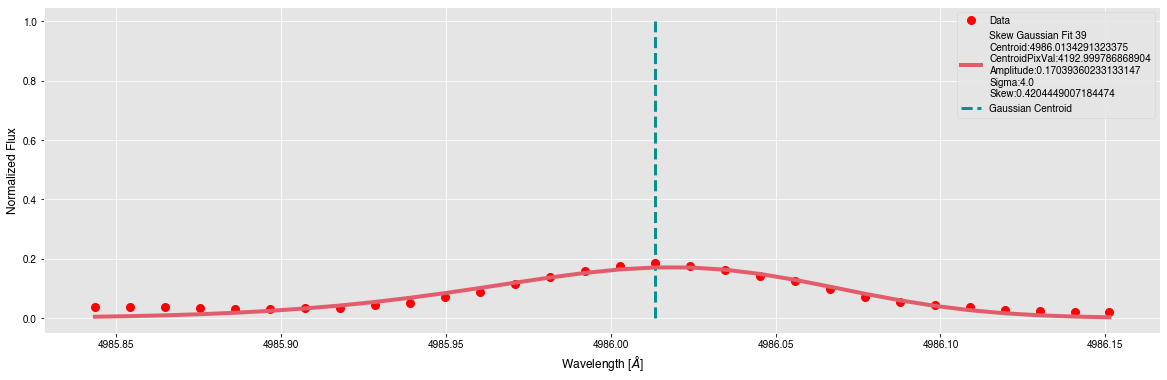

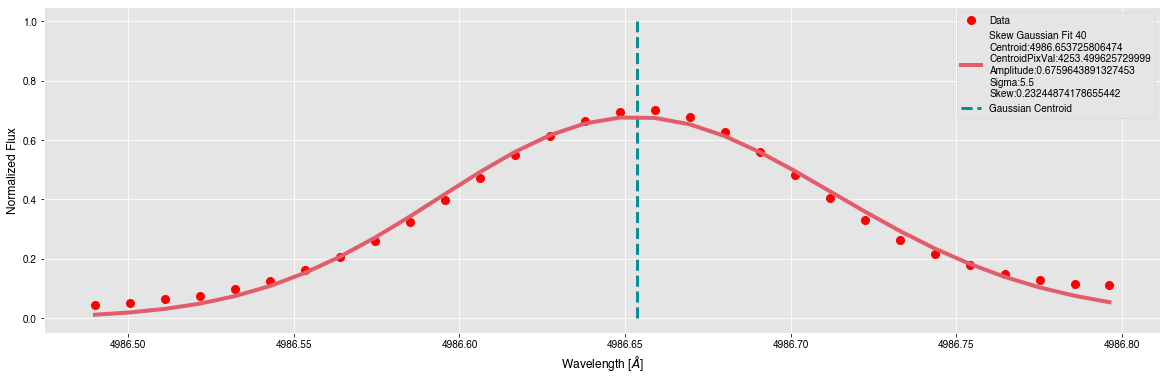

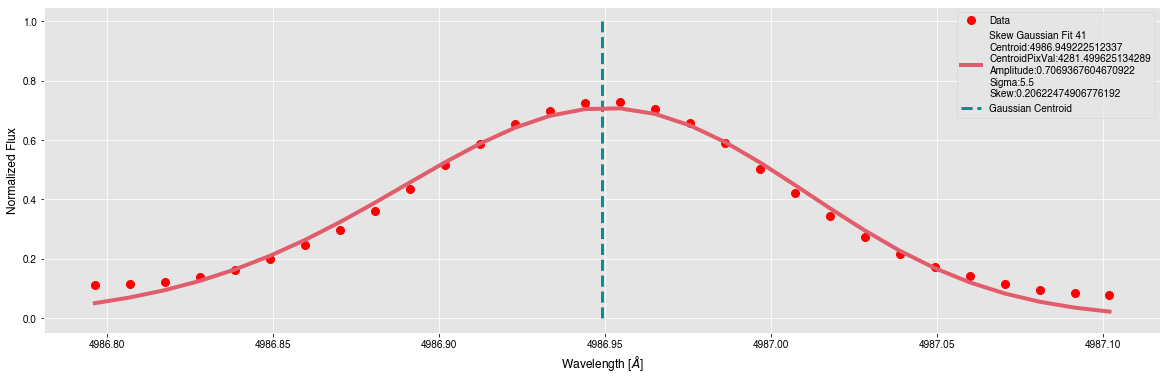

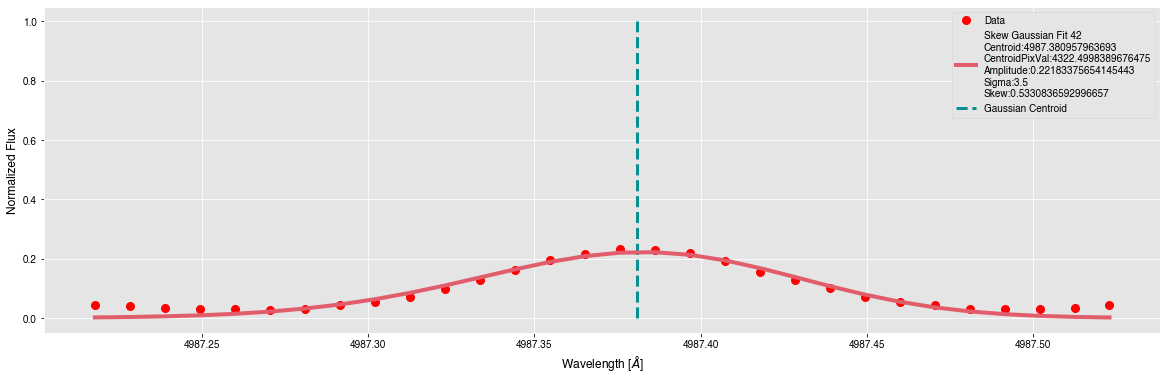

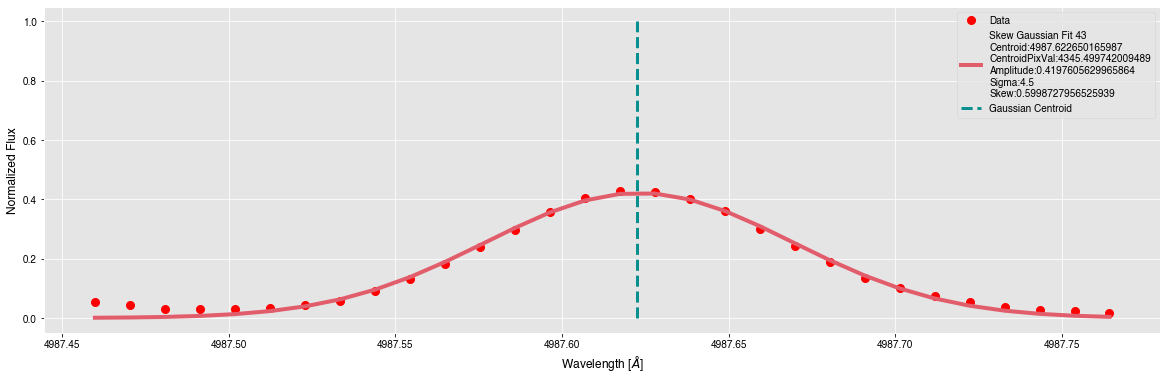

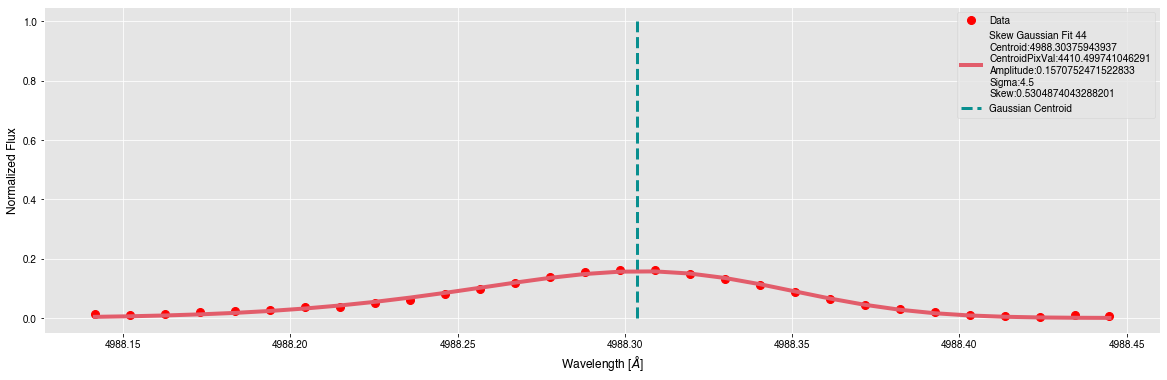

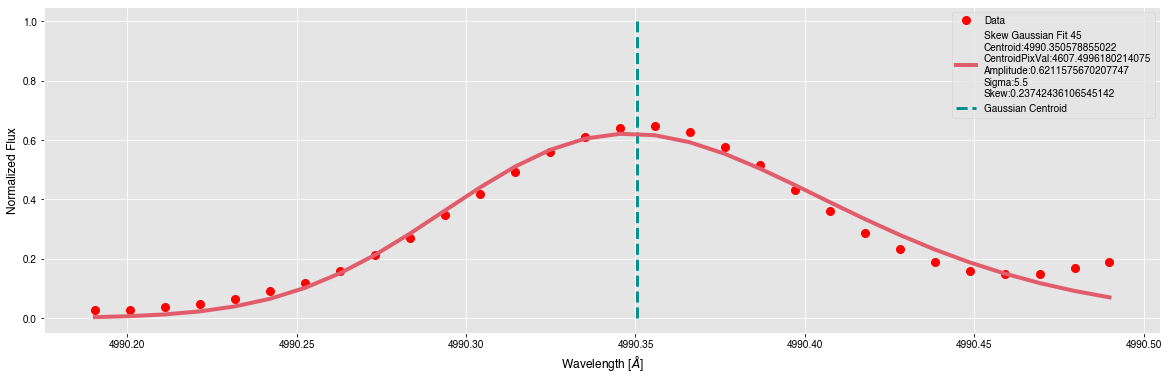

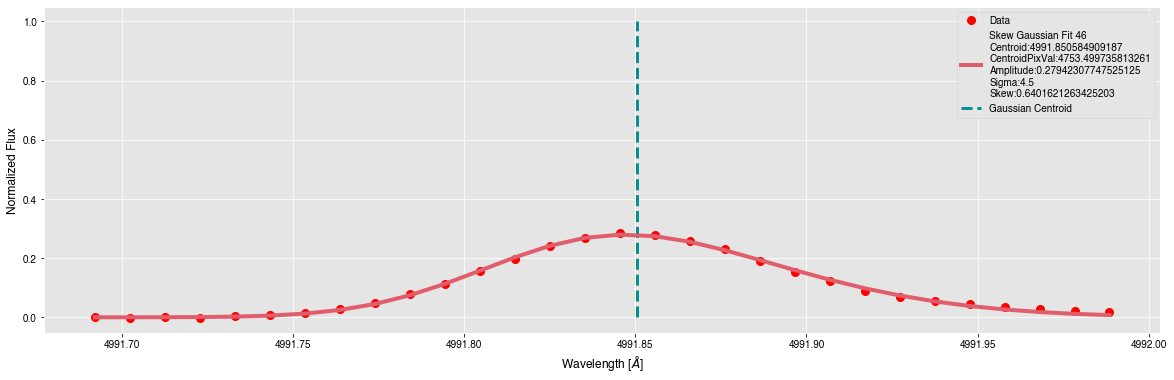

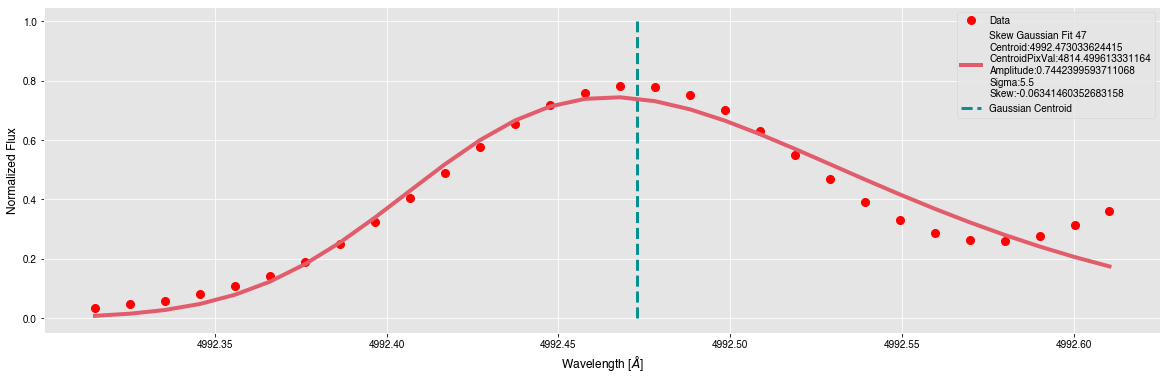

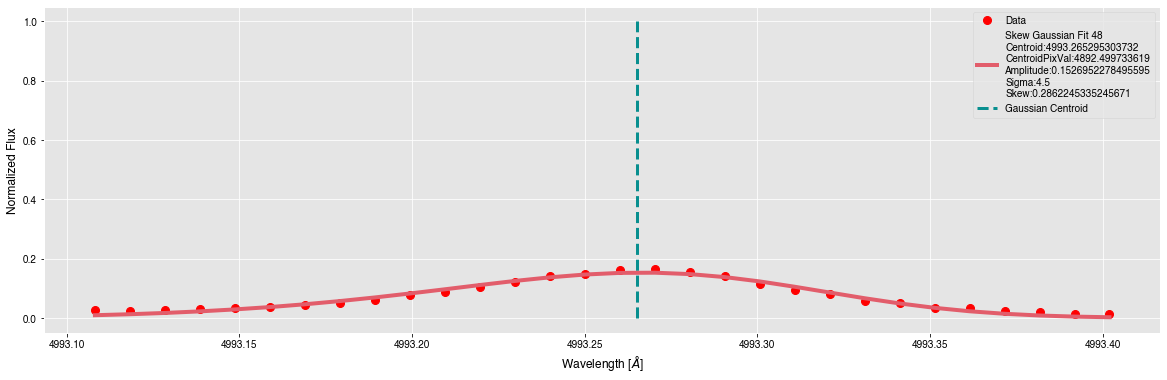

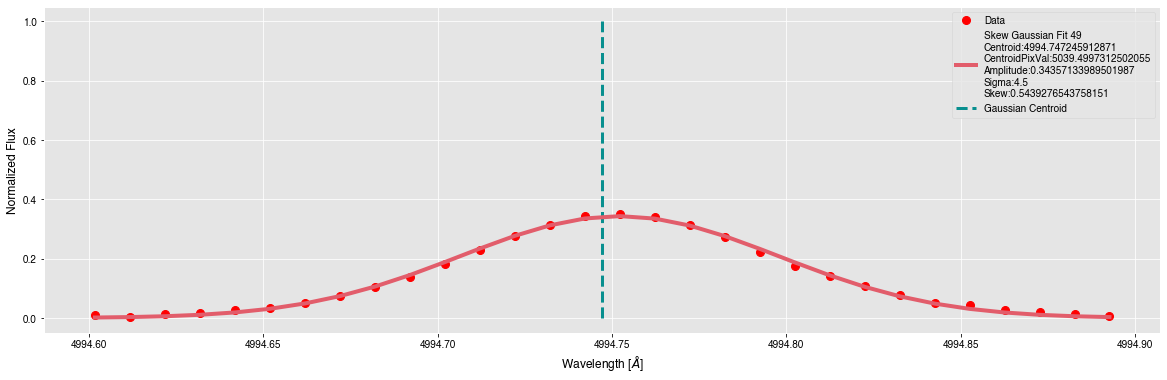

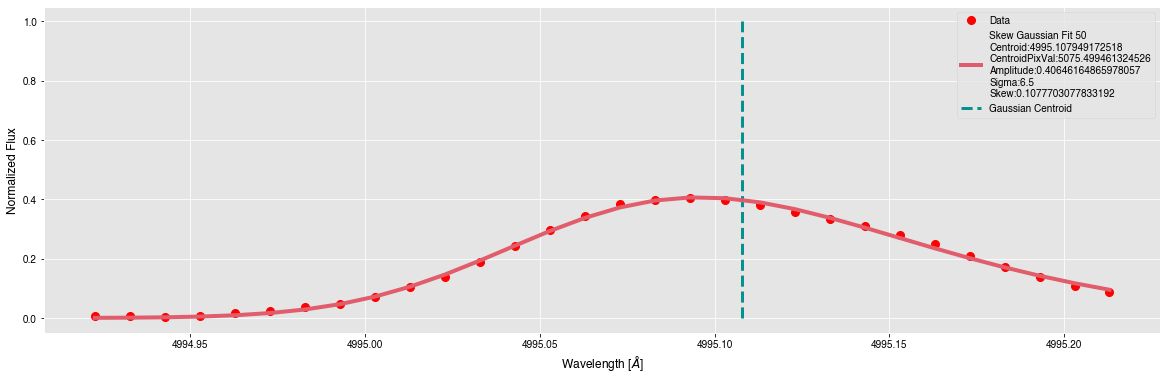

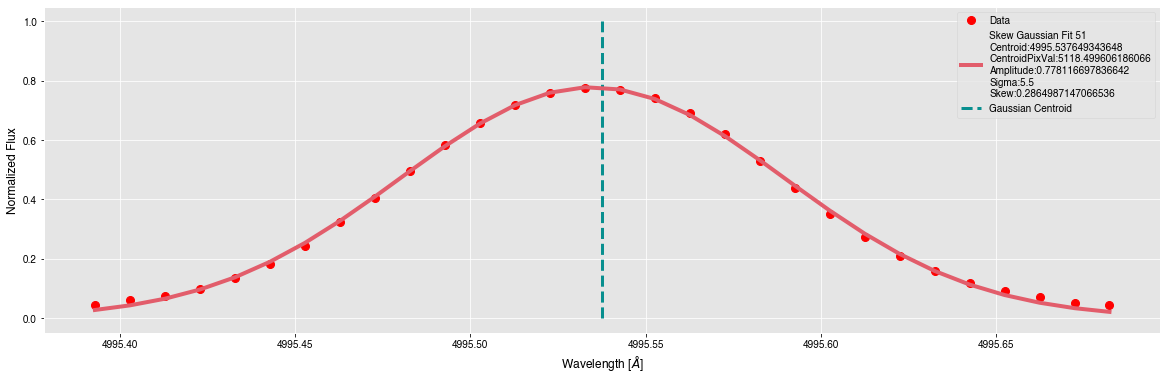

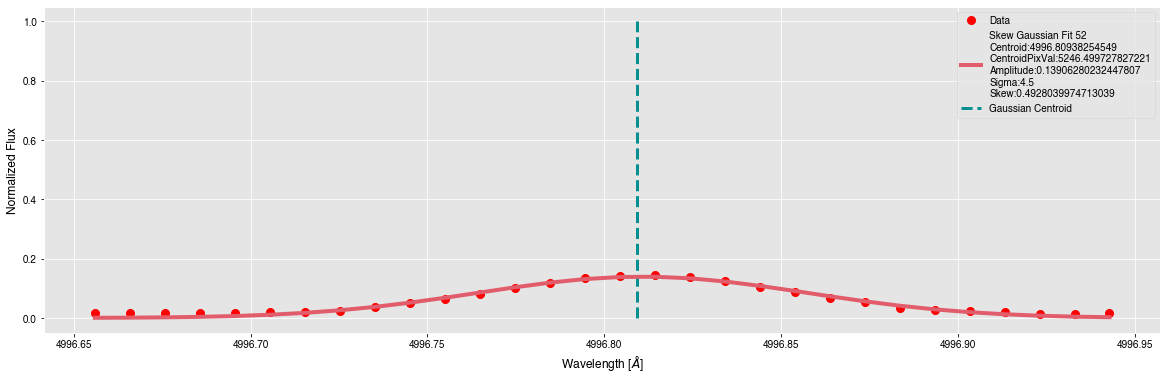

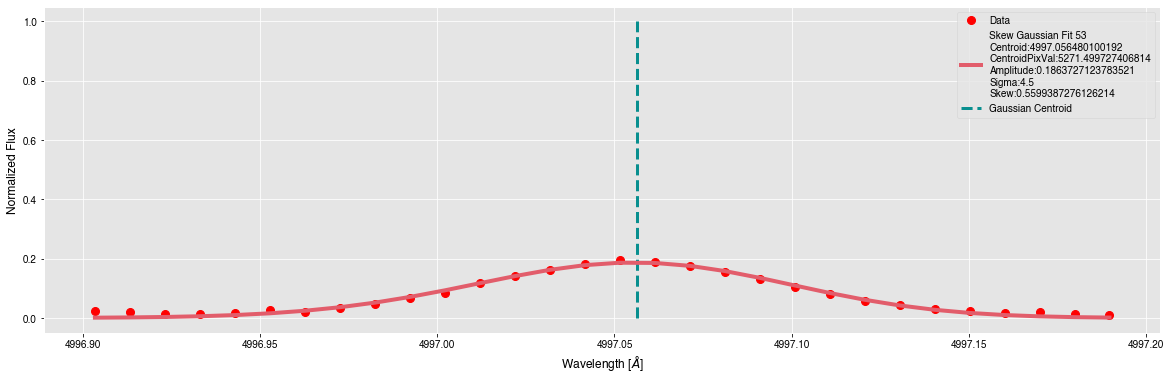

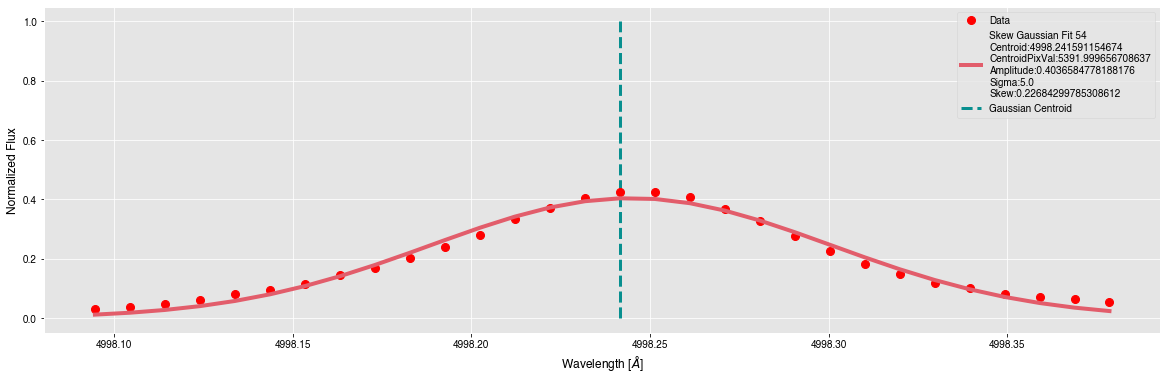

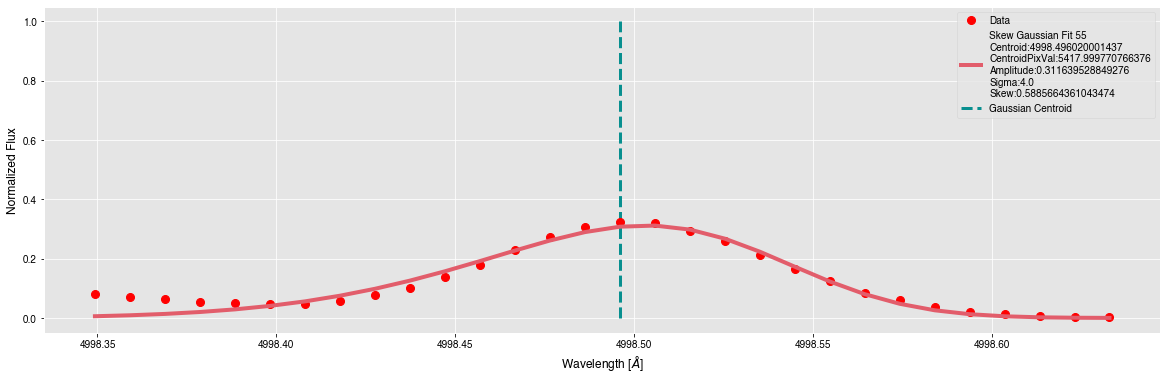

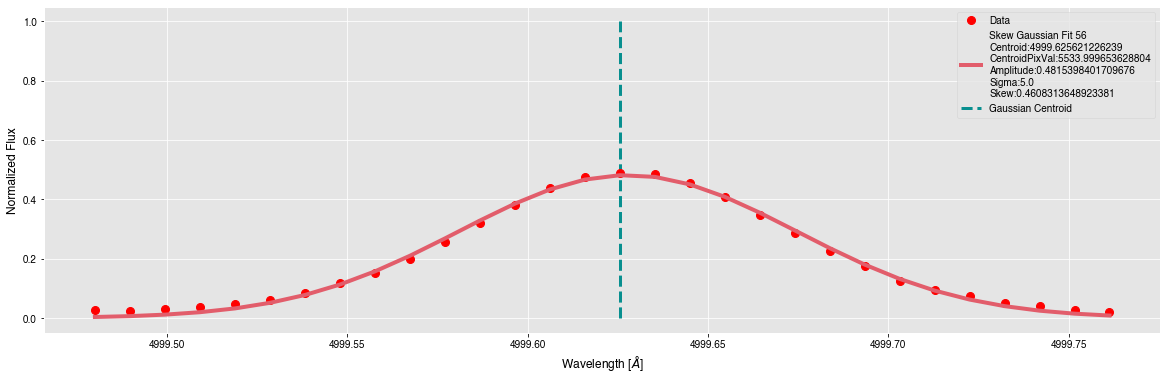

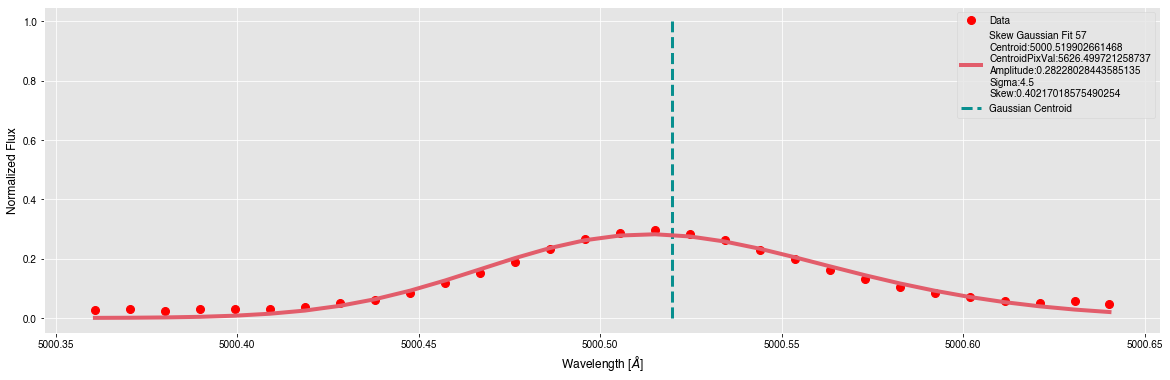

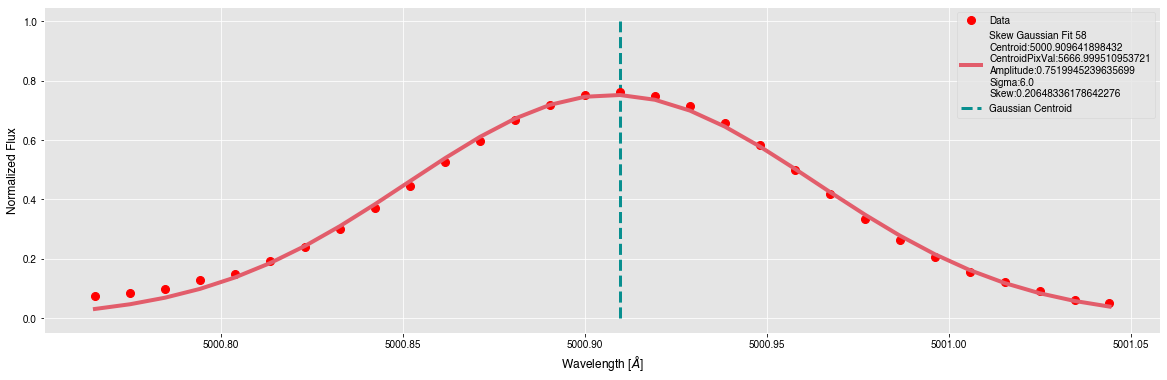

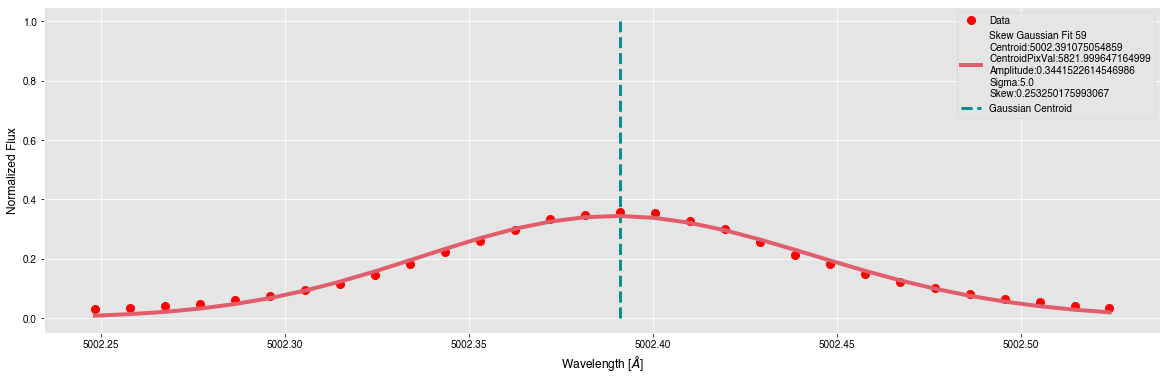

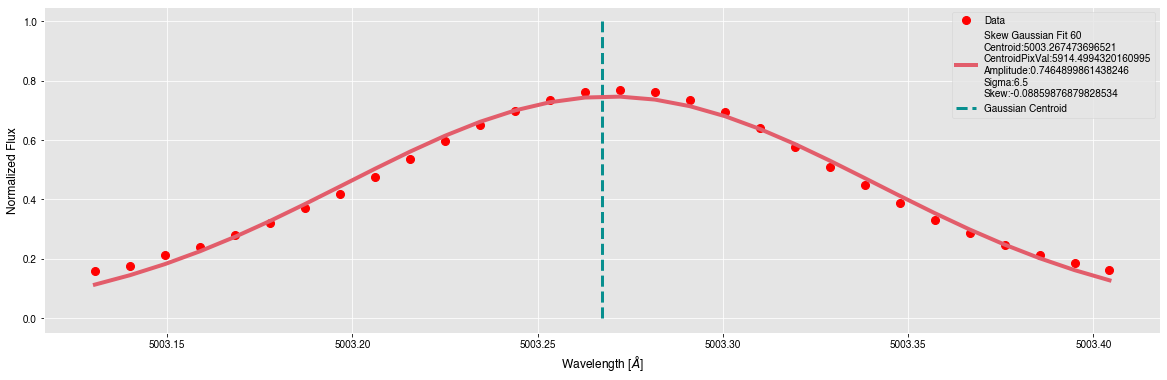

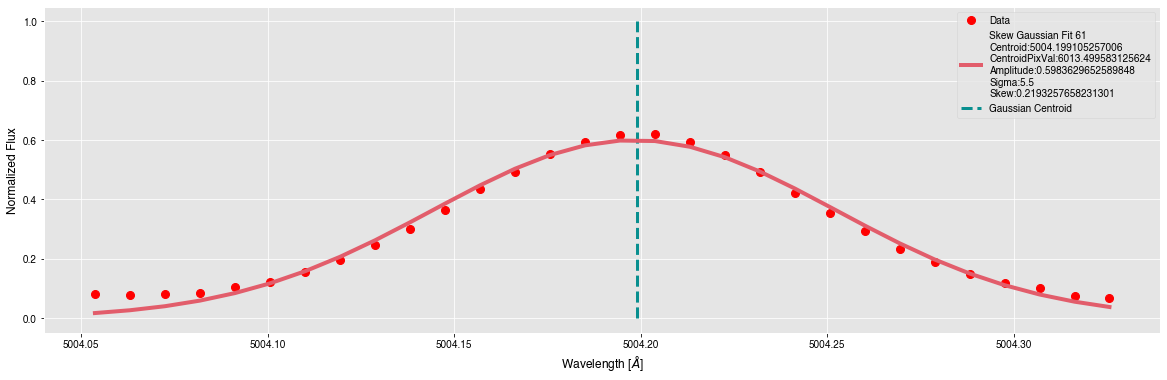

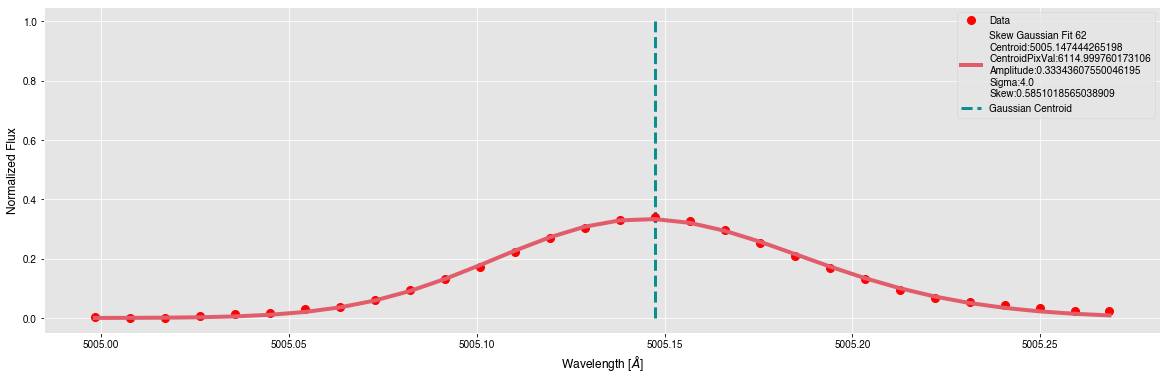

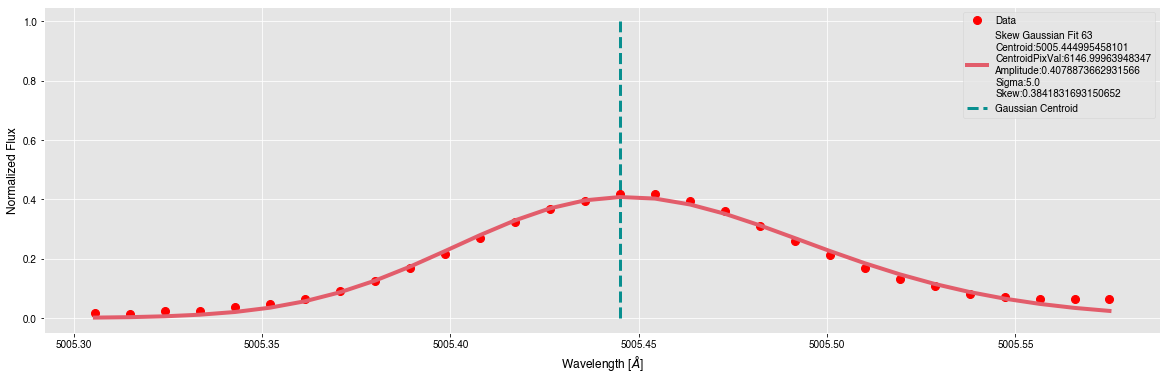

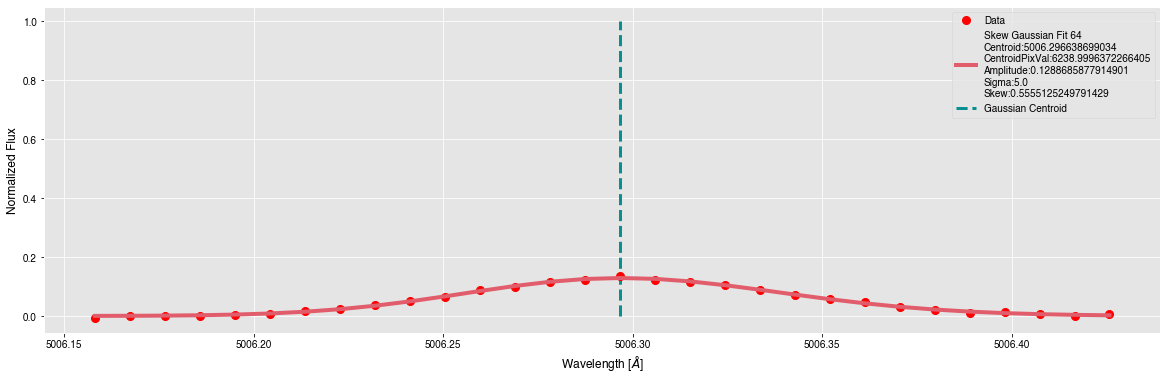

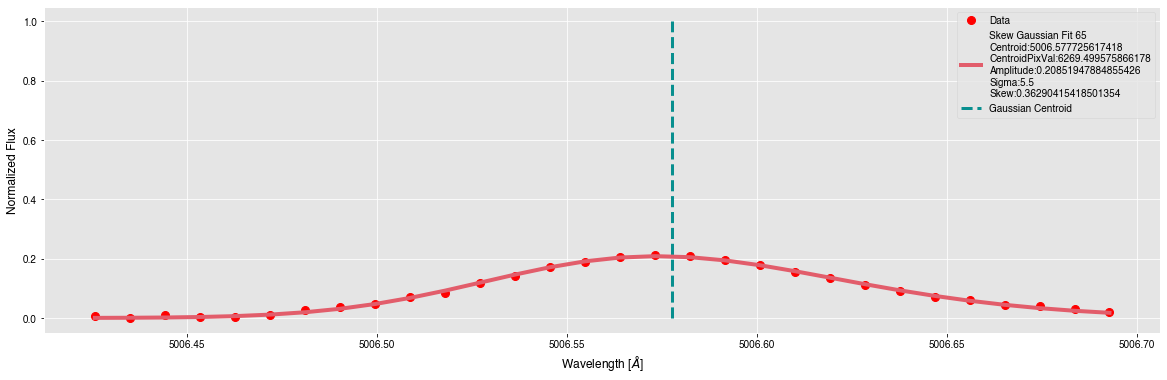

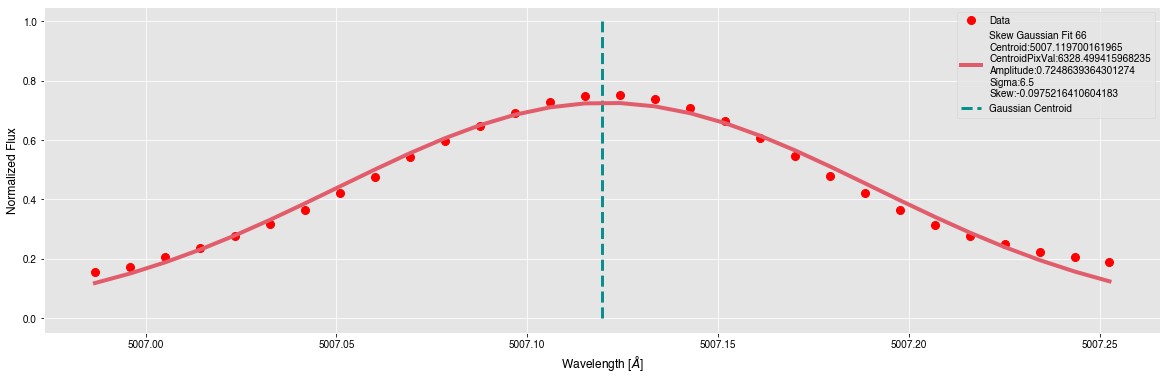

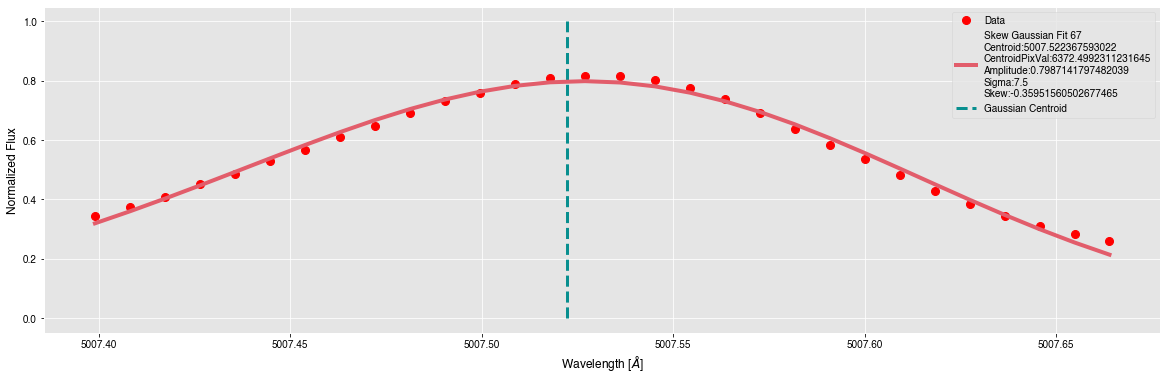

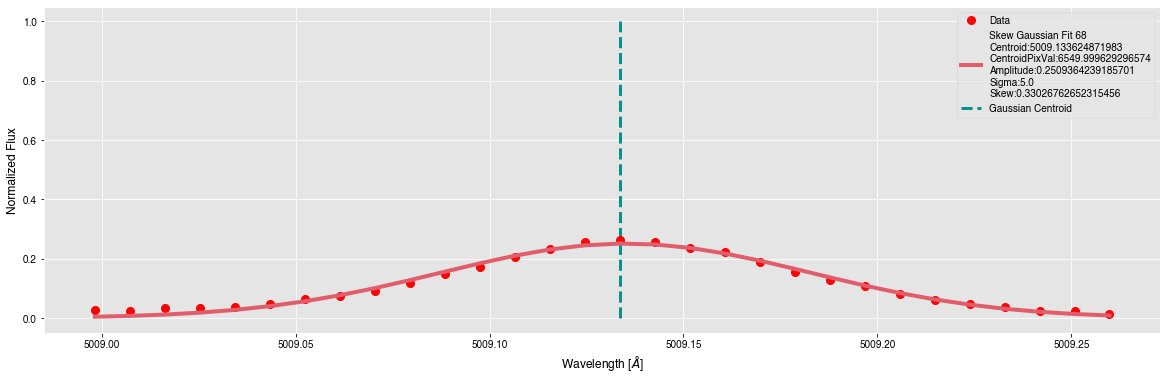

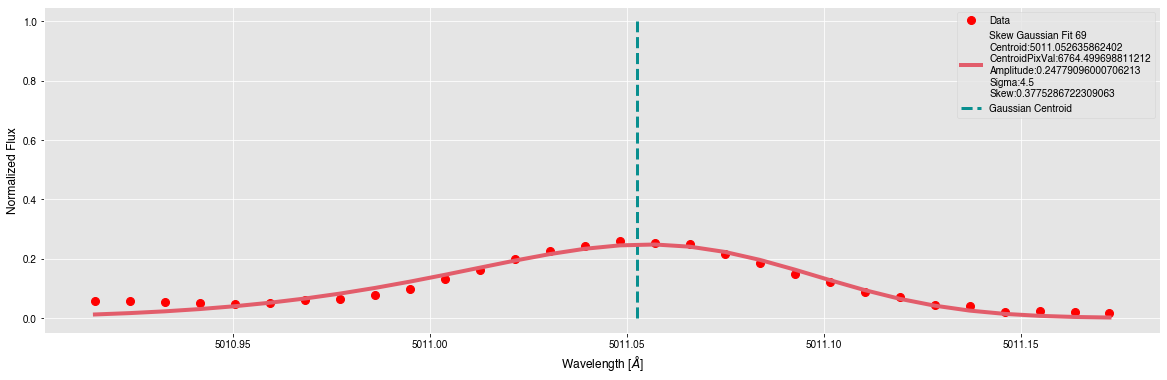

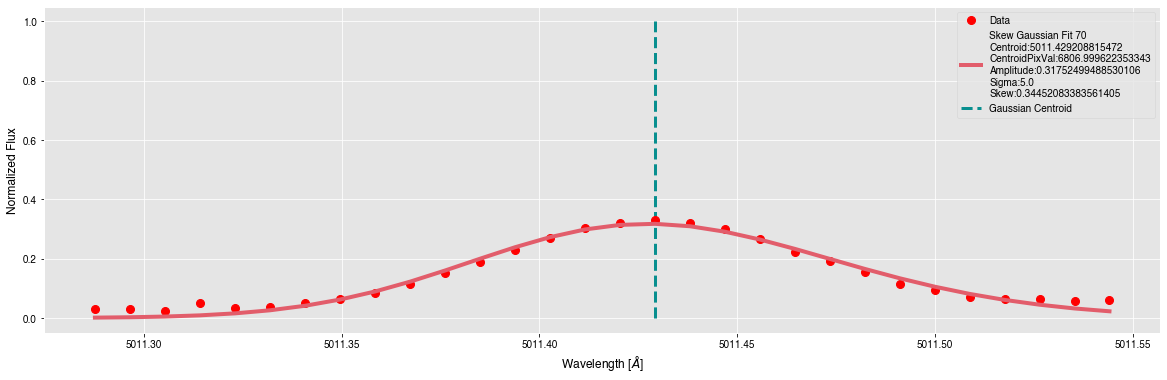

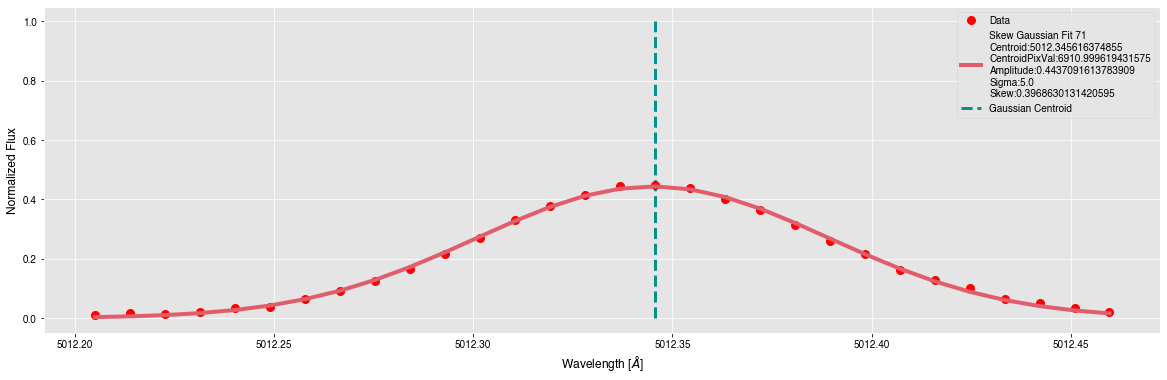

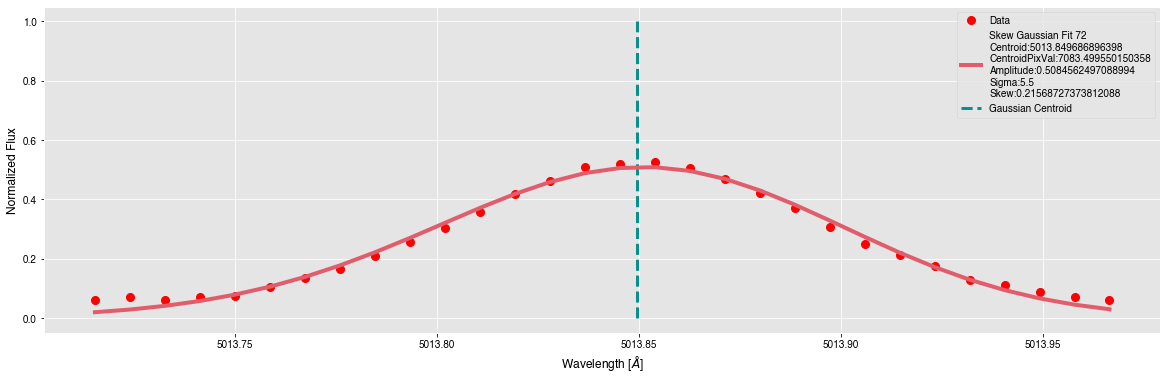

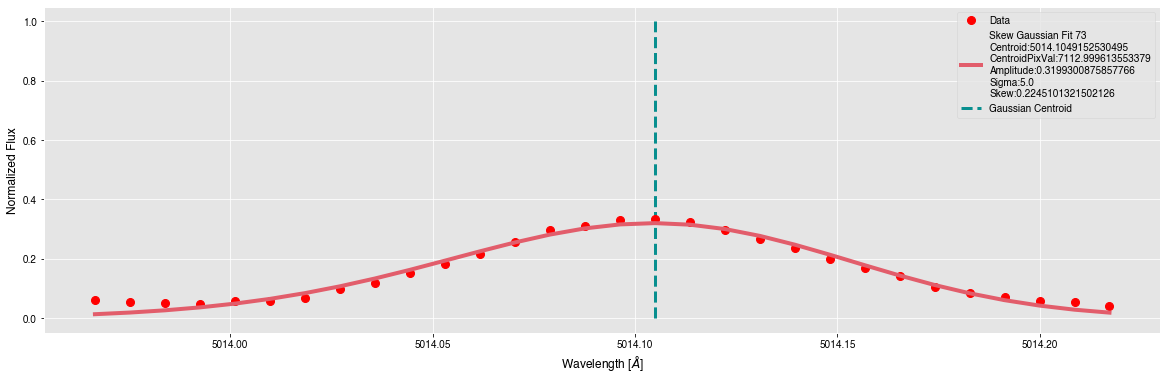

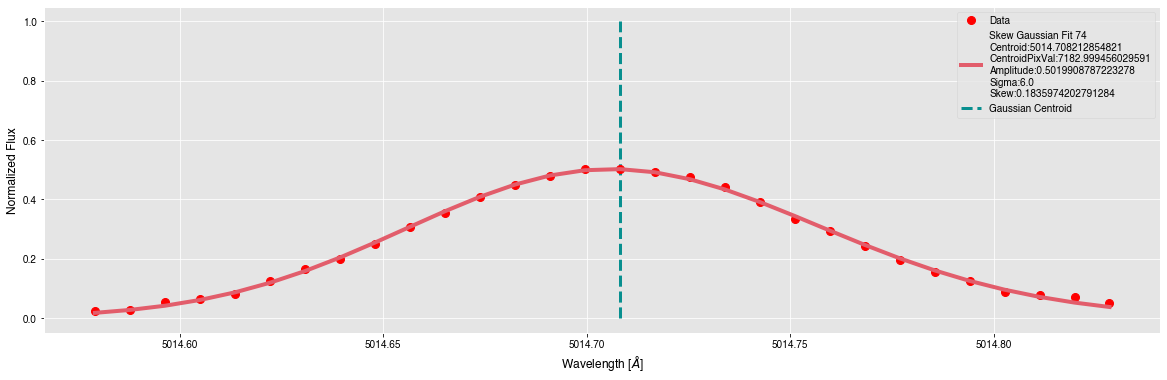

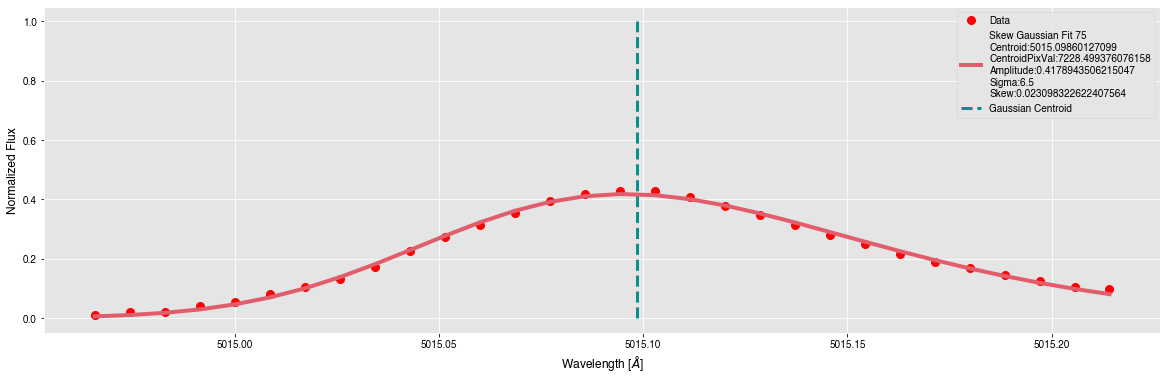

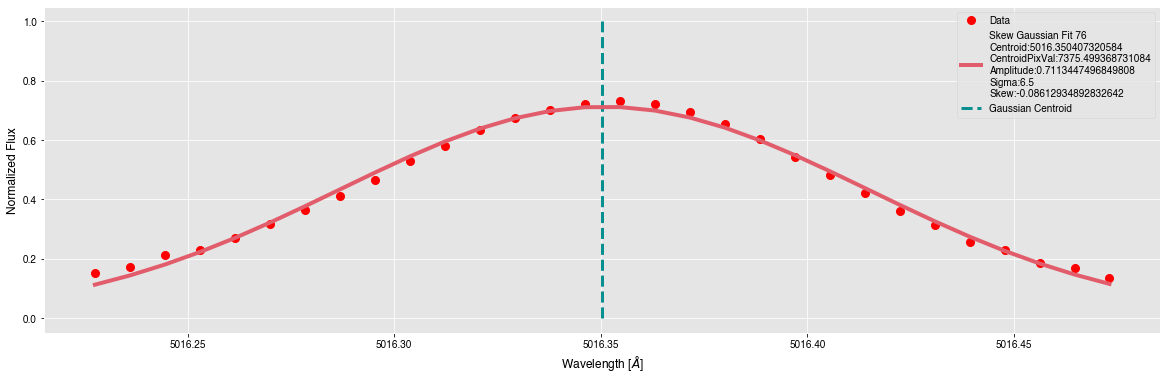

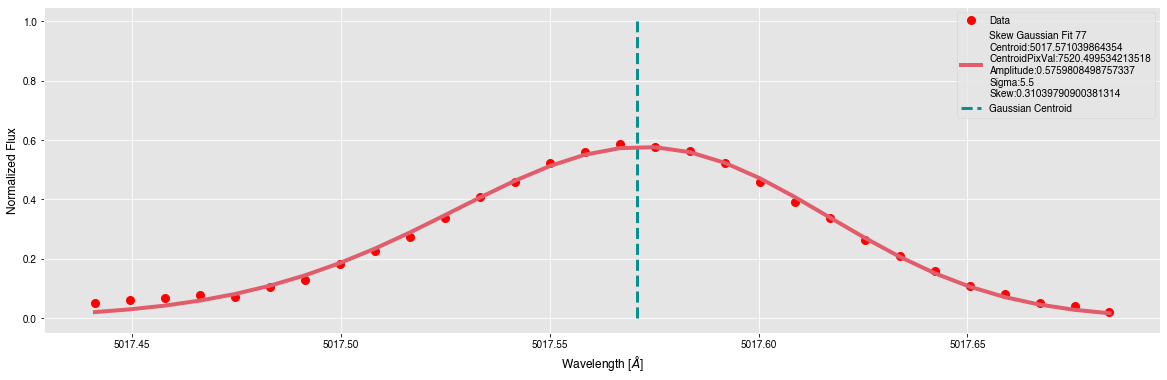

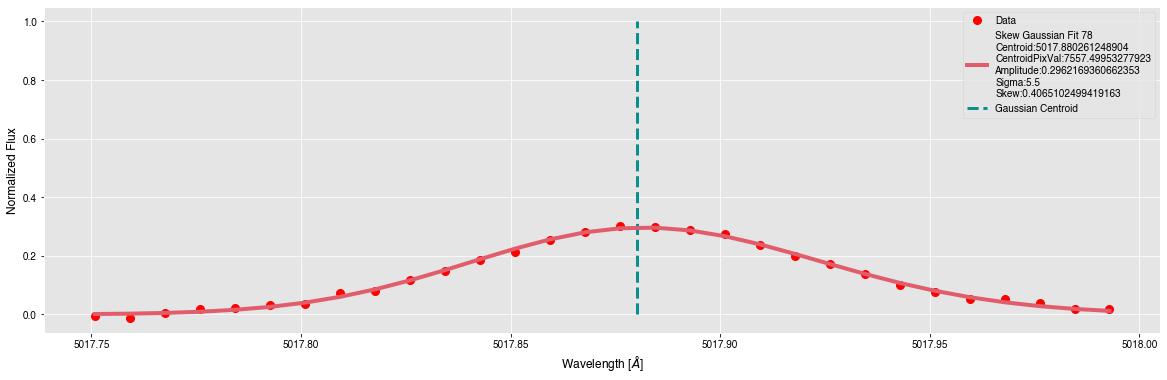

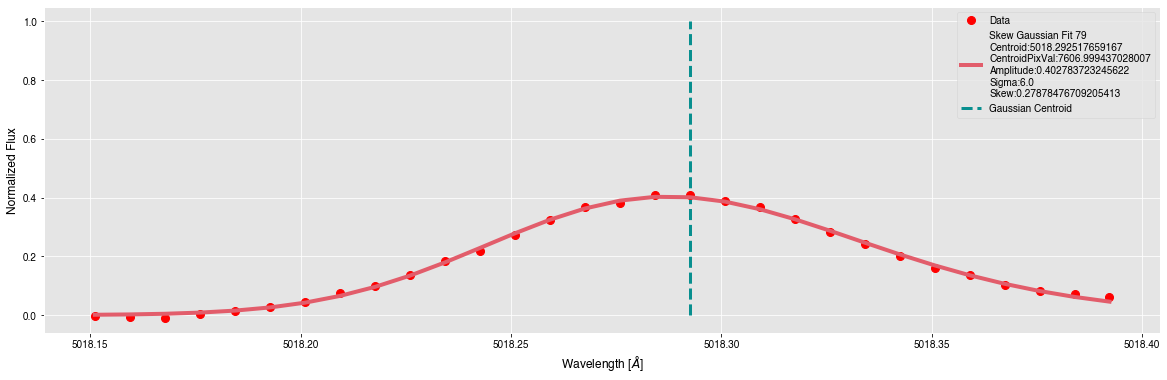

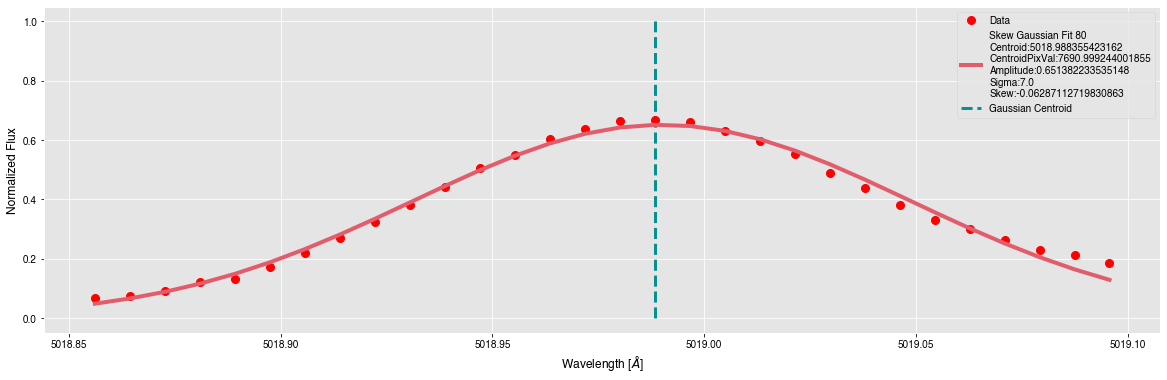

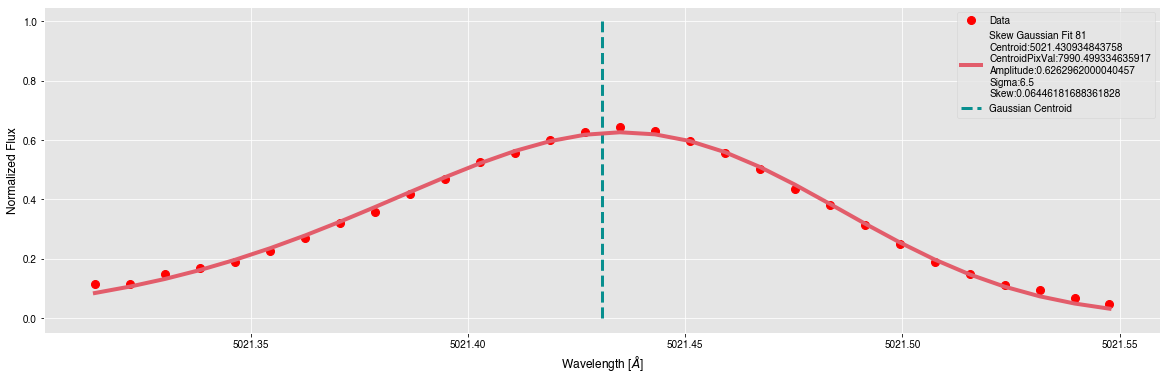

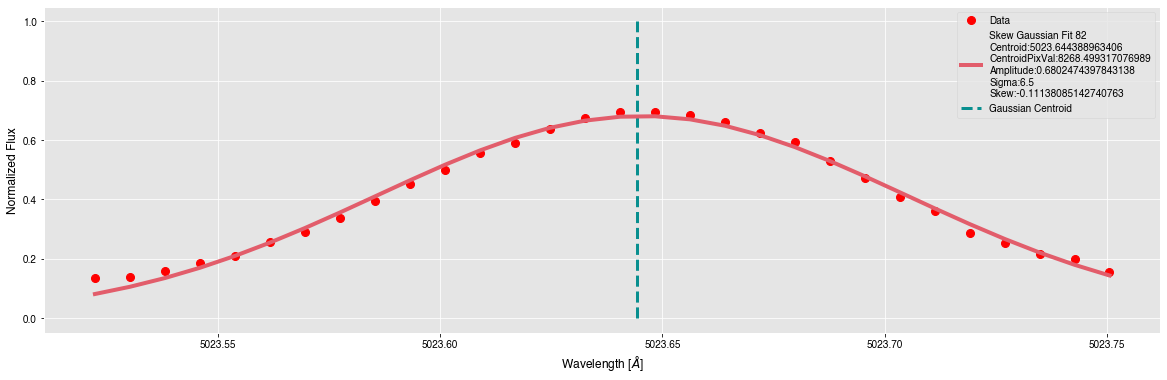

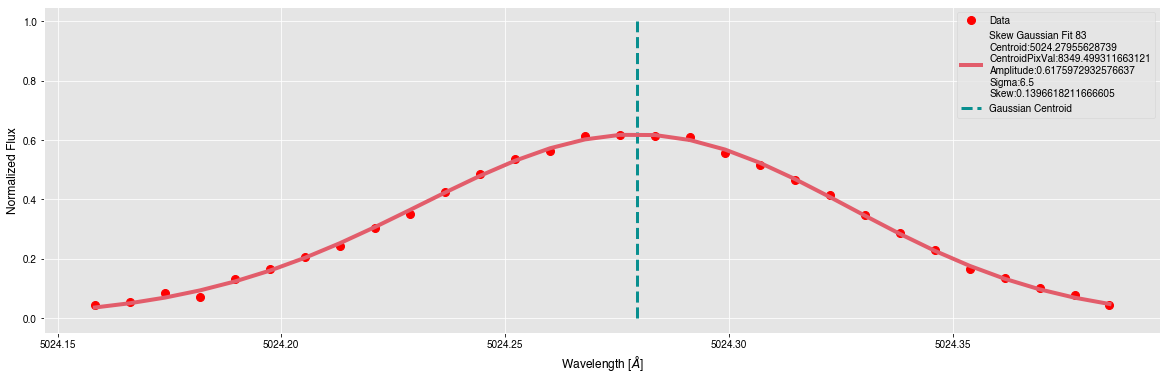

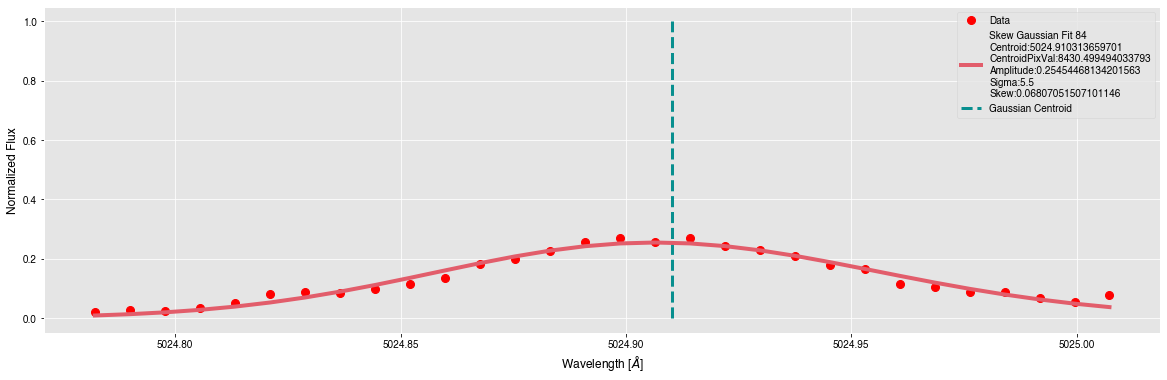

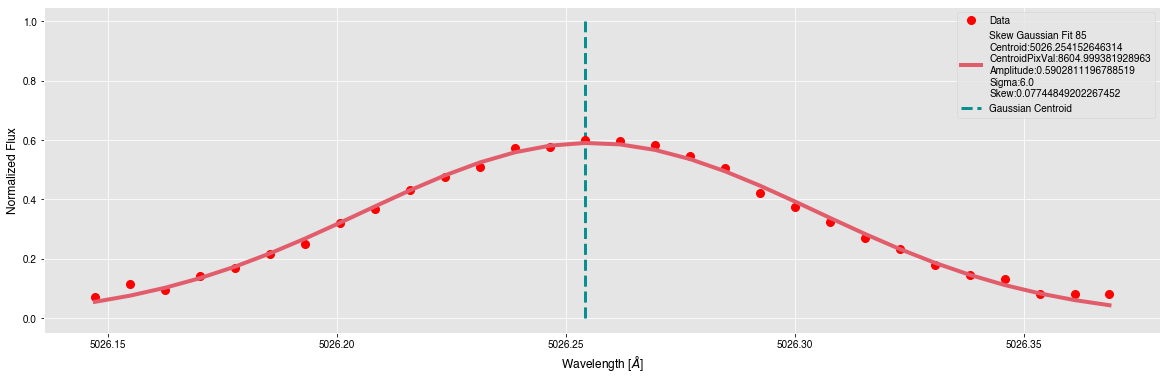

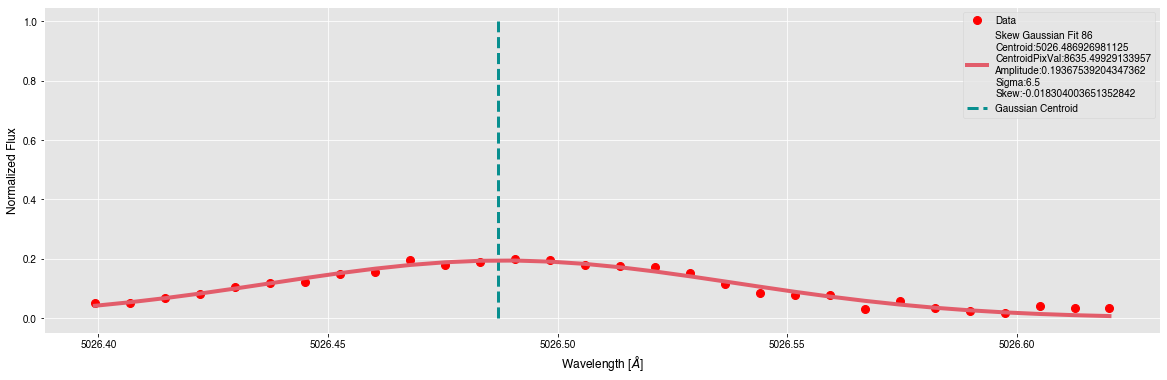

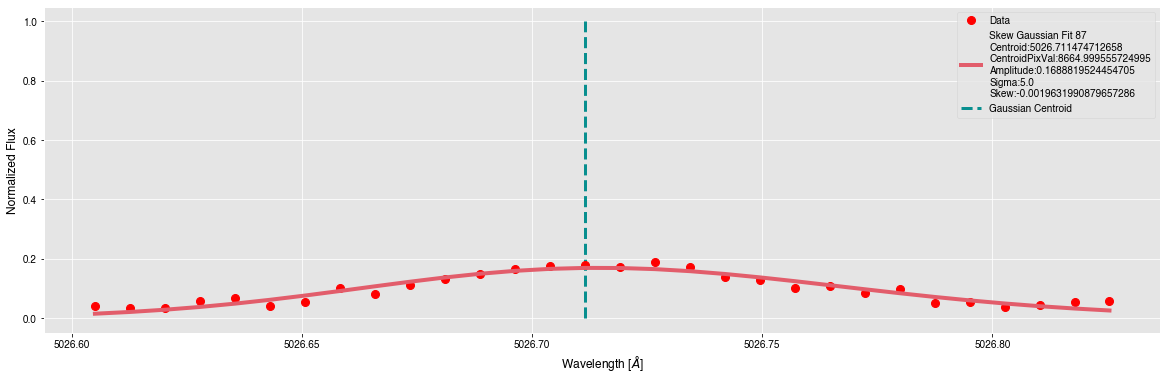

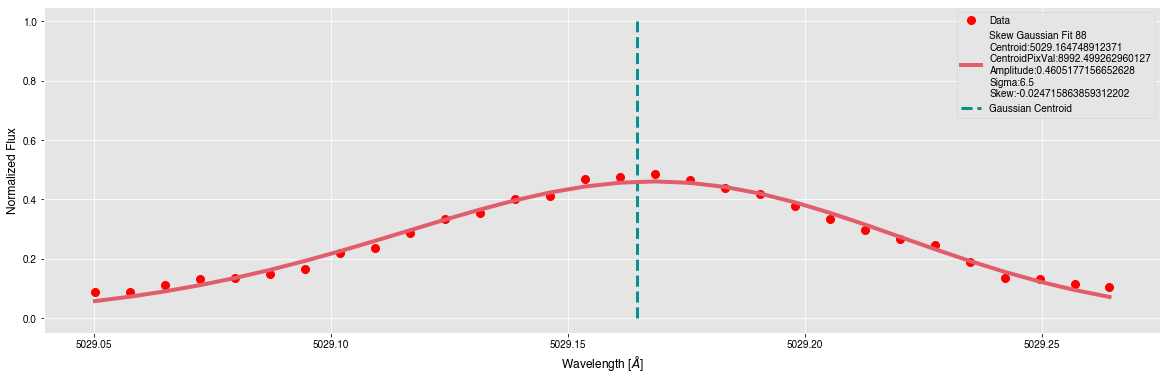

In [16]:
# Variable and List Settings
pixrange = 15
total_count = 0
filter_count = 0
centroid_list = []   

# Loop through all Lines
for linenum, val in enumerate(good_lines):
    
    # (Arpita) Chunk/Schunk Work
    schunk = result[(good_lines[linenum]-pixrange):(good_lines[linenum]+pixrange)]
    upside = -schunk + 1
    xchunk = np.arange(len(schunk))

    # Skewed Gaussian Model 'x' and 'y' Variables to Use
    skgauss_x = good_lines[linenum]+xchunk
    skgauss_y = upside
    
    # Convert to Wavelength Values
    wchunk = wave[order,(good_lines[linenum]-pixrange):(good_lines[linenum]+pixrange)]

    # Create Skewed Gaussian Model Fit
    mod = SkewedGaussianModel()
    pars = mod.guess(upside, x=wchunk)
    out = mod.fit(upside, pars, x=wchunk)

    # Find the Centroid
    height_xval = np.amax(out.best_fit, axis=0) # = amplitude
    lines_data = np.stack((skgauss_x, out.best_fit), axis=1)
    height_result = np.where(lines_data == height_xval) 
    index = height_result[0]
    centroid = pars['center'].value
    centroid_pixval = np.interp(centroid, wchunk, skgauss_x) # = (lines_data[index][0])[0] = height_yval
    
    # Find the Amplitude
    amplitude = height_xval
    
    # Create Skewed Gaussian Model Fit
    mod = SkewedGaussianModel()
    pars = mod.guess(upside, x=wchunk)
    out = mod.fit(upside, pars, x=wchunk)
    
    # Find Sigma (Pixels)
    mod2 = SkewedGaussianModel()
    pars2 = mod2.guess(skgauss_y, x=skgauss_x)
    out2 = mod2.fit(skgauss_y, pars2, x=skgauss_x)
    sigma = pars2['sigma'].value

    # Find the Skewness
    get_skew = pd.DataFrame(out.best_fit).skew()
    skew = get_skew[0]
        
    # Bounds Used to make sure Centroid within Range
    xmin_bound = np.amin(skgauss_x) + 10
    xmax_bound = np.amax(skgauss_x) - 10
    
    # Filter Quality Checks
    if (sigma >= 8) or (amplitude <= 0.1) or (amplitude >= 1) or (skew >= 1) or (skew <= -0.4): 
        filter_count += 1
        continue 
        
    # Filter where Centroids not in Range of Graph
    if (round(centroid_pixval) not in range(xmin_bound, xmax_bound)):
        filter_count += 1
        continue
        
    # Filter Any Duplicate Lines
    centroid_list.append(centroid)
    for index, centroid in enumerate(centroid_list):
        if index == 0:
            continue  
        centroid_down = centroid_list[index-1]
        if (abs(centroid - centroid_down)) <= 0.05:
            centroid_list.remove(centroid)
            break 
    if centroid not in centroid_list:
        filter_count += 1
        continue
    
    # Plot Skew Gaussian Fit for Line
    fig,ax=plt.subplots(figsize=(20,6))
    plt.plot(wchunk, upside, 'o',ms=8,label='Data', color='r')
    plt.plot(wchunk, out.best_fit,lw=4,label='Skew Gaussian Fit '+str(total_count)+'\n'+'Centroid:'+str(centroid)+'\n'+'CentroidPixVal:'+str(centroid_pixval)+'\n'+'Amplitude:'+str(amplitude)+'\n'+'Sigma:'+str(sigma)+'\n'+'Skew:'+str(skew), color='#E25D6B')
    ax.ticklabel_format(useOffset=False)
    ax.vlines(centroid,0,1,color='#088F8F',linestyle='--',lw=3,label='Gaussian Centroid')
    plt.xlabel('Wavelength [$\AA$]')
    plt.ylabel('Normalized Flux')
    plt.legend()
    
    # Add to Total Count of Fits
    total_count += 1
    
# Print Results
print('Total # of Spectral Skew-Gaussain Representations:', total_count)
print('Total # of \'Bad\' Fits Thrown Out:', filter_count)

In [17]:
# DATA CUBE FORMAT
# For each order (range 40 thru 110): Find all good lines and add to data cube
# 
# Reference File Name
#    Order 40
#       Line 2 
#          Centroid 4567.35
#          Centroid Pix Val 1245
#          Other Properties 
# File @ Time 
#    Order 
#       Corresponding Line (2)
#          Centroid 
#          Centroid Pix Val 
#          Property 
# etc...
#
#
#
#

In [18]:
start_time = time.time()
nested_dict = {}
for order_value in range(40, 111):
    # Get the Order (40-110)
    order = order_value
        
    # Replace NaN Values with Zero of Numpy Array for Wave and Flux
    x = np.nan_to_num(np.array(wave[order,:]))
    y = np.nan_to_num(np.array(flux[order,:]))

    # Combine 'x' and 'y' into Single Array
    order_data = np.stack((x, y), axis=1)

    # Pass Data through AFS Algorithm
    pd_order_data = pd.DataFrame(order_data)
    result= AFS(pd_order_data,6,0.95,0.25)
    
    # First Derivative of Blaze-Removed Spectrum (To Find Zero-Crossings)
    derivative = np.gradient(result) 

    # Second Derivative of Blaze-Removed Spectrum (To Remove Most Noise)
    derivative2 = np.gradient(derivative) 

    # Smoothed First & Second Derivatives
    smooth_derivative = savgol_filter(derivative, 11, 5)
    smooth_derivative2 = savgol_filter(derivative2, 11, 5)

    # Third Derivative of Blaze-Removed Spectrum (To Remove Duplicate Points)
    derivative3 = np.gradient(smooth_derivative2) 

    # Sort List to Split into 3 Parts and Find Avg Value of Upper Part to determine 2nd Der 'Bump' Thresholds
    sortedlist_for2 = np.sort(smooth_derivative2)
    splitlist = np.array_split(sortedlist_for2, 3)

    # Find Zero Crossings
    zero_crossing1 = np.where((smooth_derivative2 > np.mean(splitlist[2])))[0] 
    zero_crossing2 = np.where(np.diff(np.signbit(derivative3)))
    zerolist1 = zero_crossing1.tolist()
    zerolist2 = np.array(zero_crossing2).tolist()
    zero_crossings = np.array(list(set(zerolist1).intersection(zerolist2[0]))) # final list of points!
    
    # Create List of Peak Findings and Sort List
    good_lines = []
    for zero_crossing in zero_crossings:
        # (Arpita) cut off pixels at very edge of detector
        if 20 < zero_crossing < 9000: 

            # (Arpita) Make sure first derivate is going from negative to positive
            slope = smooth_derivative[zero_crossing-1] - smooth_derivative[zero_crossing+1]

            # (Arpita) Im setting these numbers after experimenting with different slope cuts
            if -0.38 < slope < -0.01:
                good_lines.append(zero_crossing)
    good_lines.sort()

    # Delete Really Close-to-Each-Other Values
    for index, i in enumerate(good_lines):
        if good_lines[-1] == i:
            break

        i_up = good_lines[index+1]
        if ((i_up-i) < 18):
            good_lines.remove(i)
            good_lines.remove(i_up)
            
    # Loop through all Lines
    pixrange, total_count = 15, 0
    centroid_list = []   
    nested_dict['Order '+str(order)] = {}
    for linenum, val in enumerate(good_lines):
        
        # (Arpita) Chunk/Shunk Work
        schunk = result[(good_lines[linenum]-pixrange):(good_lines[linenum]+pixrange)]
        upside = -schunk + 1
        xchunk = np.arange(len(schunk))

        # Skewed Gaussian Model 'x' and 'y' Variables to Use
        skgauss_x = good_lines[linenum]+xchunk
        skgauss_y = upside

        # Convert to Wavelength Values
        wchunk = wave[order,(good_lines[linenum]-pixrange):(good_lines[linenum]+pixrange)]
        wavelength_lines_data = np.stack((wchunk, out.best_fit), axis=1)

        # Create Skewed Gaussian Model Fit
        mod = SkewedGaussianModel()
        pars = mod.guess(upside, x=wchunk)
        out = mod.fit(upside, pars, x=wchunk)

        # Find the Centroid
        height_xval = np.amax(out.best_fit, axis=0) # = amplitude
        lines_data = np.stack((skgauss_x, out.best_fit), axis=1)
        height_result = np.where(lines_data == height_xval) 
        index = height_result[0]
        centroid = pars['center'].value
        centroid_pixval = np.interp(centroid, wchunk, skgauss_x) # = (lines_data[index][0])[0] = height_yval

        # Find the Normalized Amplitude
        norm_amplitude = height_xval
        
        # Find Sigma (Pixels)
        mod2 = SkewedGaussianModel()
        pars2 = mod2.guess(skgauss_y, x=skgauss_x)
        out2 = mod2.fit(skgauss_y, pars2, x=skgauss_x)
        sigma = pars2['sigma'].value

        # Find the Skewness
        get_skew = pd.DataFrame(out.best_fit).skew()
        skew = get_skew[0]

        # Bounds Used to make sure Centroid within Range
        xmin_bound = np.amin(skgauss_x) + 10
        xmax_bound = np.amax(skgauss_x) - 10

        # Filter Quality Checks
        if (sigma >= 8) or (amplitude <= 0.1) or (amplitude >= 1) or (skew >= 1) or (skew <= -0.4): 
            filter_count += 1
            continue 

        # Filter where Centroids not in Range of Graph
        if (round(centroid_pixval) not in range(xmin_bound, xmax_bound)):
            filter_count += 1
            continue

        # Filter Any Duplicate Lines
        centroid_list.append(centroid)
        for index, centroid in enumerate(centroid_list):
            if index == 0:
                continue  
            centroid_down = centroid_list[index-1]
            if (abs(centroid - centroid_down)) <= 0.05:
                centroid_list.remove(centroid)
                break 
        if centroid not in centroid_list:
            filter_count += 1
            continue

        
        # Append Nested Dictionary Values
        nested_dict['Order '+str(order)]['Line '+str(total_count)] = {}
        nested_dict['Order '+str(order)]['Line '+str(total_count)]['centroid'] = centroid
        nested_dict['Order '+str(order)]['Line '+str(total_count)]['centroid_pixval'] = centroid_pixval
        nested_dict['Order '+str(order)]['Line '+str(total_count)]['norm_amplitude'] = norm_amplitude
        nested_dict['Order '+str(order)]['Line '+str(total_count)]['elec_amplitude'] = 0
        nested_dict['Order '+str(order)]['Line '+str(total_count)]['sigma'] = sigma
        nested_dict['Order '+str(order)]['Line '+str(total_count)]['skew'] = skew
        
        # Add to Total Count of Lines
        total_count += 1

print('Completed in ',(time.time() - start_time),' seconds')

Completed in  840.2912757396698  seconds


In [2]:
# Save the Nested Dictionary
#np.save('main_datalist.npy', nested_dict) 

# Read and Print the Nested Dictionary from Saved File
main_datalist = np.load('main_datalist.npy',allow_pickle='TRUE').item()

# Fin!
print('The Main Data Cube has been created for the Reference Lines!')
print('')
print('Final Data Cube for this Reference File:') 
print(main_datalist)

The Main Data Cube has been created for the Reference Lines!

Final Data Cube for this Reference File:
{'Order 40': {'Line 0': {'centroid': 4565.043609581428, 'centroid_pixval': 54.49969530453974, 'norm_amplitude': 0.7873025658243837, 'elec_amplitude': 0, 'sigma': 5.5, 'skew': -0.29426680909991776}, 'Line 1': {'centroid': 4567.801257013877, 'centroid_pixval': 276.999823937941, 'norm_amplitude': -0.0, 'elec_amplitude': 0, 'sigma': 4.0, 'skew': 0.0}, 'Line 2': {'centroid': 4569.623823636186, 'centroid_pixval': 425.4997871695243, 'norm_amplitude': -0.0, 'elec_amplitude': 0, 'sigma': 4.5, 'skew': 0.0}, 'Line 3': {'centroid': 4570.020785125451, 'centroid_pixval': 457.9995026201146, 'norm_amplitude': 1.1665698134840838, 'elec_amplitude': 0, 'sigma': 7.0, 'skew': 0.04086557885284094}, 'Line 4': {'centroid': 4570.873454876354, 'centroid_pixval': 527.9996256935664, 'norm_amplitude': -0.0, 'elec_amplitude': 0, 'sigma': 6.0, 'skew': 0.0}, 'Line 5': {'centroid': 4572.3881551468385, 'centroid_pixva

In [3]:
 # Create Time Axis
ref_file_time = '20210208T191024' 
time_folder = {}
time_folder['Time '+str(ref_file_time)] = main_datalist

# Save Final Dictionary @ Checkpoint
np.save('omega_datalist.npy', time_folder) 

In [4]:
start_time = time.time()

# Prepare Directory
file_dir = os.listdir('./NEID_Sun')
NEID_Sun = [s for s in file_dir if 'neid' in s]
NEID_Sun.sort()

# Loop through all Files
for file in NEID_Sun:
    # Open the FITS File
    hdul = fits.open('./NEID_Sun/'+str(file))

    # Get Flux and Wave Data
    flux = hdul['SCIFLUX'].data
    wave = hdul['SCIWAVE'].data
    
    # Get the Date-Time for File
    file.replace('.fits', '')
    file_time = (file.split('_',1)[1]).partition('.')[0]
    
    # Check if already Looped 
    time_folder = np.load('omega_datalist.npy',allow_pickle='TRUE').item()
    completed_times = []
    for timeval in time_folder:
        timeval = timeval.replace('Time ', '')
        completed_times.append(timeval)
    
    if file_time in completed_times:
        continue

    # Loop through Orders 40-110
    time_folder['Time '+str(file_time)] = {}
    for order in range(40,111):
        # Get Reference File Lines for Order
        ref_lines = time_folder['Time '+str(ref_file_time)]['Order '+str(order)]
        
        # Get Order Variables
        x = np.nan_to_num(np.array(wave[order,:]))
        y = np.nan_to_num(np.array(flux[order,:]))
        
        # Loop through each Reference Line and find Matching Fit
        time_folder['Time '+str(file_time)]['Order '+str(order)] = {}
        for index, ref_line in enumerate(ref_lines): 
            # Reference Centroid (in Pixels)
            ref_centroid_pixval = ref_lines['Line '+str(index)]['centroid_pixval'] - 15
            rounded_ref_centroid_pixval = int(round(ref_centroid_pixval))

            # If wish to perform tests, use below format
            #ref_anyval = ref_order_lines['Line '+str(index)]['anyval']
            ref_sigma = ref_lines['Line '+str(index)]['sigma']

            # Schunk/Chunk Work
            order_data = np.stack((x, y), axis=1)
            schunk = order_data[(rounded_ref_centroid_pixval-15):(rounded_ref_centroid_pixval+15)][:,1]
            upside = -schunk + max(schunk)
            norm_upside = upside / max(upside)
            xchunk = list(range(0,30))

            # Skewed Gaussian Model 'x' and 'y' Variables to Use
            skgauss_x = ref_centroid_pixval+xchunk
            skgauss_y = upside

            # Chunk (in Wavelength) & Create Skewed Gaussian Model Fit
            wchunk = wave[order,(rounded_ref_centroid_pixval-15):(rounded_ref_centroid_pixval+15)]
            mod = SkewedGaussianModel()
            pars = mod.guess(norm_upside, x=wchunk)
            out = mod.fit(norm_upside, pars, x=wchunk)

            # Reference Centroid (in Wavelength)
            ref_centroid_wave = np.interp(ref_lines['Line '+str(index)]['centroid_pixval'], skgauss_x, wchunk)
            
            # Find the Centroid
            fit_centroid = pars['center'].value
            fit_centroid_pixval = np.interp(fit_centroid, wchunk, skgauss_x)

            # Find the Amplitude
            mod2 = SkewedGaussianModel()
            pars2 = mod2.guess(upside, x=wchunk)
            out2 = mod2.fit(upside, pars2, x=wchunk)
            electron_amp = pars2['amplitude'].value
            
            p = np.percentile(out2.best_fit, 2)
            REALdepth = 
            
            # Find Sigma
            mod2 = SkewedGaussianModel()
            pars2 = mod2.guess(skgauss_y, x=skgauss_x)
            out2 = mod2.fit(skgauss_y, pars2, x=skgauss_x)
            sigma = pars2['sigma'].value

            # Find the Skewness
            get_skew = pd.DataFrame(out.best_fit).skew()
            skew = get_skew[0]
            
            # Append Nested Dictionary Values 
            time_folder['Time '+str(file_time)]['Order '+str(order)]['Line '+str(index)] = {}
            time_folder['Time '+str(file_time)]['Order '+str(order)]['Line '+str(index)]['centroid'] = fit_centroid
            time_folder['Time '+str(file_time)]['Order '+str(order)]['Line '+str(index)]['centroid_pixval'] = fit_centroid_pixval
            time_folder['Time '+str(file_time)]['Order '+str(order)]['Line '+str(index)]['norm_amplitude'] = 0
            time_folder['Time '+str(file_time)]['Order '+str(order)]['Line '+str(index)]['elec_amplitude'] = electron_amp
            time_folder['Time '+str(file_time)]['Order '+str(order)]['Line '+str(index)]['sigma'] = sigma
            time_folder['Time '+str(file_time)]['Order '+str(order)]['Line '+str(index)]['skew'] = skew 
            
            """ QUALITY TESTS & IF WISH TO PRINT (don't unless you want to kill your computer)
            # print(index, ref_centroid_pixval+15, fit_centroid_pixval) --- # PASSED 
            # print(index, ref_centroid_wave, fit_centroid) --- # PASSED
            # print(index, ref_amp, amplitude) --- # PASSED
            # print(index, ref_skew, skew) --- # PASSED
            # print(index, ref_sigma, sigma) --- # PASSED

            fig,ax=plt.subplots(figsize=(20,6))
            plt.plot(wchunk,norm_upside,'o',ms=8,label='Data', color='r')
            plt.plot(wchunk,out.best_fit,lw=3,label='Skewed Gaussian Fit '+str(index))
            ax.ticklabel_format(useOffset=False)
            plt.title('Line '+str(index), fontsize=25)
            plt.axvline(ref_centroid_wave,0,1,color='#088F8F',linestyle='--',lw=3,label='Reference Centroid '+str(ref_centroid_wave))
            plt.axvline(fit_centroid,0,1,color='#E25D6B',linestyle='--',lw=3,label='Fit Centroid '+str(fit_centroid))
            plt.xlabel('Wavelength [$\AA$]')
            plt.ylabel('Flux [Electrons]')
            plt.legend()
            """
        # Save File Data to Dictionary Checkpoint
        if order == 110:
            np.save('omega_datalist.npy', time_folder) 
                                               
print('Completed in ',(time.time() - start_time),' seconds')

Completed in  30370.399961948395  seconds


In [5]:
# Read the Final Dictionary from Saved File
omega_datalist = np.load('omega_datalist.npy',allow_pickle='TRUE').item()

# Fin!
print('The FINAL Data Cube has been created; the purpose of this notebook has been completed!!')
print(':D')

The FINAL Data Cube has been created; the purpose of this notebook has been completed!!
:D
